<a href="https://colab.research.google.com/github/ArthurChan-1111/Bitcoin_prediction/blob/main/Master_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Packages

In [2]:
# Check if running in Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install pandas_ta
    !pip install numpy==1.23.5
    !pip install pandas
    !pip install seaborn
    !pip install xgboost
    
    !git clone https://github.com/ArthurChan-1111/Bitcoin_prediction.git
    
    %cd Bitcoin_prediction
    %pip install pandas_ta
else:
    print("Not running in Colab, skipping git clone and directory change")

Not running in Colab, skipping git clone and directory change


In [4]:
# Importing libraries for data manipulation
import numpy as np
import pandas as pd
import pandas_ta as ta
import csv

# Importing libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for scaling the data
from sklearn.preprocessing import MinMaxScaler

# Importing libraries for building linear regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import summary_table, OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from statsmodels.stats.stattools import durbin_watson as dwtest
from statsmodels.sandbox.stats.runs import runstest_1samp
from statsmodels.stats.diagnostic import het_white

from statsmodels.compat import lzip

import statsmodels.stats.api as sms

from scipy import stats
from scipy.stats import zscore

from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold, cross_val_score

import pylab as py

# To help with model building
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

# To tune model, get different metric scores, and split data
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To impute missing values
from sklearn.impute import SimpleImputer

# To do hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

# To suppress scientific notations
pd.set_option("display.float_format", lambda x: "%.4f" % x)

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)


#Load dataset

In [6]:
btc_data = pd.read_csv('Bitcoin Historical Data.csv', on_bad_lines='skip', lineterminator='\n')
btc_data.tail(5)

,Date,Price,Open,High,Low,Vol. ('000),Change %\r
4107,1/5/2014,1014.7000,924.7000,1029.9000,911.4000,21.37,9.74%\r
4108,1/4/2014,924.7000,884.3000,932.2000,848.3000,14.24,4.57%\r
4109,1/3/2014,884.3000,856.9000,888.2000,839.4000,9.71,3.19%\r
4110,1/2/2014,856.9000,815.9000,886.2000,810.5000,12.81,5.02%\r
4111,1/1/2014,815.9000,805.9000,829.9000,771.0000,10.76,1.24%


In [7]:
# Check if 'Change %\r' exists and rename it to 'Change'
if 'Change %\r' in btc_data.columns:
    btc_data.rename(columns={'Change %\r': 'Change'}, inplace=True)

In [8]:
# Convert the dictionary to a DataFrame
btc_data = pd.DataFrame(btc_data)

# Parse the "Date" column into datetime format
btc_data["Date"] = pd.to_datetime(btc_data["Date"], format="%m/%d/%Y")

# Sort the data by date in ascending order
btc_data.sort_values(by="Date", ascending=True, inplace=True)


In [9]:
gold_price_data = pd.read_csv('gold_price_data.csv', on_bad_lines='skip', lineterminator='\n', sep=';')
gold_price_data.tail(5)

,Date,Gold_Price,Gold_Volume\r
4047,2025-01-30,2794.0600,83835.0000
4048,2025-01-31,2799.2300,91164.0000
4049,2025-02-01,2799.2300,91164.0000
4050,2025-02-02,2799.2300,91164.0000
4051,2025-02-03,2794.4100,1631.0000


In [10]:
# Check if 'Gold_Volume %\r' exists and rename it to 'Gold_Volume %'
if 'Gold_Volume\r' in gold_price_data.columns:
    gold_price_data.rename(columns={'Gold_Volume\r': 'Gold_Volume'}, inplace=True)

In [11]:
risk_free_data = pd.read_csv('risk_free_data.csv', on_bad_lines='skip', lineterminator='\n', sep=',')
risk_free_data.tail(5)

,Date,US_10Y,Yield_Spread\r
4126,2025-04-19,4.3400,0.5300
4127,2025-04-20,4.3400,0.5300
4128,2025-04-21,4.4200,0.6700
4129,2025-04-22,4.4100,0.6500
4130,2025-04-23,4.4000,0.5900


In [12]:
# rename the Yield_Spread\r to Yield_Spread
risk_free_data.rename(columns={'Yield_Spread\r': 'Yield_Spread'}, inplace=True)

In [13]:
spy_data = pd.read_csv('spy_data.csv', on_bad_lines='skip', lineterminator='\n', sep=',')
spy_data.tail(5)

,Date,SPY_Price,SPY_Volume\r
4114,2025-04-07,504.3800,256611400.0000
4115,2025-04-08,496.4800,165816600.0000
4116,2025-04-09,548.6200,241867300.0000
4117,2025-04-10,524.5800,162331200.0000
4118,2025-04-11,533.9400,97741700.0000


In [14]:
# Check if 'SPY_Volume\r' exists and rename it to 'SPY_Volume'
if 'SPY_Volume\r' in spy_data.columns:
    spy_data.rename(columns={'SPY_Volume\r': 'SPY_Volume'}, inplace=True)

In [15]:
eth_data = pd.read_csv('eth_data.csv', on_bad_lines='skip', lineterminator='\n', sep=',')

# Remove the dollar sign and convert 'ETH_Price' to a numeric type
eth_data['ETH_Price'] = eth_data['ETH_Price'].replace('[\$,]', '', regex=True).astype(float)

eth_data.tail(5)

FileNotFoundError: [Errno 2] No such file or directory: 'eth_data.csv'

In [ ]:
# Check if 'eth_Volume\r' exists and rename it to 'eth_Volume'
if 'eth_Volume\r' in eth_data.columns:
    eth_data.rename(columns={'eth_Volume\r': 'eth_Volume'}, inplace=True)

In [ ]:
#Change the 'Date' to datetime format
gold_price_data['Date'] = pd.to_datetime(gold_price_data['Date'])
risk_free_data['Date'] = pd.to_datetime(risk_free_data['Date'])
spy_data['Date'] = pd.to_datetime(spy_data['Date'])
eth_data['Date'] = pd.to_datetime(eth_data['Date'])

#Data Preprocessing

In [ ]:
#Function to clean and convert volume data
def clean_volume(volume):
    if isinstance(volume, str):  # Check if the value is a string
        volume = volume.replace(',', '')  # Remove commas
        if 'B' in volume:  # If the value contains 'B' (billions)
            return float(volume.replace('B', '')) * 1_000_000_000
        elif 'M' in volume:  # If the value contains 'M' (millions)
            return float(volume.replace('M', '')) * 1_000_000
        elif 'K' in volume:  # If the value contains 'K' (thousands)
            return float(volume.replace('K', '')) * 1_000
        else:  # If no suffix is present, convert to float directly
            return float(volume)
    return np.nan  # Handle unexpected cases

# Apply the cleaning function to the volume column
btc_data["Volume"] = btc_data["Vol. ('000)"].apply(clean_volume)
btc_data = btc_data.drop("Vol. ('000)", axis=1)

# 4. Remove '%' from "Change %" and convert to numeric
btc_data.rename(columns={"Change %\r": "Change"}, inplace=True)
btc_data["Change"] = btc_data["Change"].str.replace("%", "").str.strip().astype(float)

In [ ]:
# Define the missing data as a dictionary
missing_data = {
    'Date': '01/12/2025',
    'Price': 94541.8,
    'Open': 94600.0,
    'High': 95384.3,
    'Low': 93711.2,
    'Volume': 17.60,  # Assuming 'Vol. (\'000)' is in thousands
    'Change': -0.07  # Assuming 'Change %' is already converted to a float
}

# Convert the dictionary to a DataFrame
missing_data_df = pd.DataFrame([missing_data])

# Ensure the 'Date' column is in datetime format
missing_data_df['Date'] = pd.to_datetime(missing_data_df['Date'])

# Append the missing data to btc_data
btc_data = pd.concat([btc_data, missing_data_df], ignore_index=True)

# Filter the data for the date range 01/10/2025 to 01/20/2025
filtered_data = btc_data[(btc_data['Date'] >= '2025-01-10') & (btc_data['Date'] <= '2025-01-20')]

# Display the filtered data
print(filtered_data)

In [ ]:
# Day of the week (0=Monday, 6=Sunday)
btc_data["Day_of_Week"] = btc_data["Date"].dt.dayofweek

# Week of the year
btc_data["Week_of_Year"] = btc_data["Date"].dt.isocalendar().week

# Month of the year
btc_data["Month"] = btc_data["Date"].dt.month

# Quarter of the year
btc_data["Quarter"] = btc_data["Date"].dt.quarter

# Year
btc_data["Year"] = btc_data["Date"].dt.year

## Signal Detection

In [ ]:
# Calculate RSI, EMA, SMA, and MACD
btc_data["RSI_6"] = ta.rsi(btc_data["Price"], length=6)  # Relative Strength Index
btc_data["RSI_12"] = ta.rsi(btc_data["Price"], length=12)  # Relative Strength Index
btc_data["EMA_14"] = ta.ema(btc_data["Price"], length=14)  # Exponential Moving Average
btc_data["SMA_14"] = ta.sma(btc_data["Price"], length=14)  # Simple Moving Average

# Add On-Balance Volume (OBV)
btc_data["OBV"] = ta.obv(btc_data["Price"], btc_data["Volume"])

# Calculate MACD --------------------------------------------------------------------------------------
macd = ta.macd(btc_data["Price"], fast=12, slow=26, signal=9)
btc_data["MACD"] = macd["MACD_12_26_9"]
btc_data["MACD_Signal"] = macd["MACDs_12_26_9"]

# Create MACD_buy: 1 if MACD crosses above MACD_Signal, otherwise 0
btc_data["MACD_buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["MACD"] > btc_data["MACD_Signal"]) &  # MACD is above Signal
    (btc_data["MACD"].shift(1) <= btc_data["MACD_Signal"].shift(1)),  # Previous MACD was below or equal to Signal
    "MACD_buy"] = 1  # Buy signal

# Create MACD_sell: 1 if MACD crosses below MACD_Signal, otherwise 0
btc_data["MACD_sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["MACD"] <= btc_data["MACD_Signal"]) &  # MACD is below or equal to Signal
    (btc_data["MACD"].shift(1) > btc_data["MACD_Signal"].shift(1)),  # Previous MACD was above Signal
    "MACD_sell"] = 1  # Sell signal

# New Variable: MACD_above_signal (1 if MACD > MACD_Signal, otherwise 0)
btc_data["MACD_above_signal"] = (btc_data["MACD"] > btc_data["MACD_Signal"]).astype(int)

# New Variable: MACD_below_signal (1 if MACD <= MACD_Signal, otherwise 0)
btc_data["MACD_below_signal"] = (btc_data["MACD"] <= btc_data["MACD_Signal"]).astype(int)

# Create MACD_cum_buy: Accumulate consecutive days where MACD_above_signal is 1
btc_data["MACD_cum_buy"] = (
    btc_data["MACD_above_signal"]
    .groupby((btc_data["MACD_above_signal"] == 0).cumsum())  # Group by resets when MACD_above_signal is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["MACD_above_signal"] == 0, "MACD_cum_buy"] = 0  # Reset to 0 where the condition is not met

# Create MACD_cum_sell: Accumulate consecutive days where MACD_below_signal is 1
btc_data["MACD_cum_sell"] = (
    btc_data["MACD_below_signal"]
    .groupby((btc_data["MACD_below_signal"] == 0).cumsum())  # Group by resets when MACD_below_signal is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["MACD_below_signal"] == 0, "MACD_cum_sell"] = 0  # Reset to 0


# Calculate Bollinger Bands --------------------------------------------------------------------------------------
bb = ta.bbands(btc_data["Price"], length=20, std=2)  # 20-period BB with 2 standard deviations
btc_data["BB_upper"] = bb.get("BBU_20_2.0")  # Upper Bollinger Band
btc_data["BB_lower"] = bb.get("BBL_20_2.0")  # Lower Bollinger Band

# Create BB_Buy: 1 if Price crosses below the Lower Band, otherwise 0
btc_data["BB_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["BB_lower"]) &  # Price is below the Lower Band
    (btc_data["Price"].shift(1) >= btc_data["BB_lower"].shift(1)),  # Previous Price was above or equal to Lower Band
    "BB_Buy"] = 1  # Buy signal

# Create BB_Sell: 1 if Price crosses above the Upper Band, otherwise 0
btc_data["BB_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["BB_upper"]) &  # Price is above the Upper Band
    (btc_data["Price"].shift(1) <= btc_data["BB_upper"].shift(1)),  # Previous Price was below or equal to Upper Band
    "BB_Sell"] = 1  # Sell signal

# New Variable: Price_above_lower_band (1 if Price > BB_lower, otherwise 0)
btc_data["Price_below_BB_lower"] = (btc_data["Price"] < btc_data["BB_lower"]).astype(int)

# New Variable: Price_below_upper_band (1 if Price < BB_upper, otherwise 0)
btc_data["Price_above_BB_upper"] = (btc_data["Price"] > btc_data["BB_upper"]).astype(int)

# Create BB_cum_Buy: Accumulate consecutive days where Price_below_BB_lower is 1
btc_data["BB_cum_Buy"] = (
    btc_data["Price_below_BB_lower"]
    .groupby((btc_data["Price_below_BB_lower"] == 0).cumsum())  # Group by resets when Price_below_BB_lower is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["Price_below_BB_lower"] == 0, "BB_cum_Buy"] = 0  # Reset to 0 where the condition is not met

# Create BB_cum_Sell: Accumulate consecutive days where Price_above_BB_upper is 1
btc_data["BB_cum_Sell"] = (
    btc_data["Price_above_BB_upper"]
    .groupby((btc_data["Price_above_BB_upper"] == 0).cumsum())  # Group by resets when Price_above_BB_upper is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["Price_above_BB_upper"] == 0, "BB_cum_Sell"] = 0  # Reset to 0 where the condition is not met

# Calculate ATR --------------------------------------------------------------------------------------
btc_data["ATR"] = ta.atr(btc_data["High"], btc_data["Low"], btc_data["Price"], length=14)

# Set Stop-Loss Levels (Example with Long Trade)
atr_multiplier = 2
btc_data["Stop_Loss_Long"] = btc_data["Price"] - (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Buy (Long) Trade
btc_data["Stop_Loss_Short"] = btc_data["Price"] + (btc_data["ATR"] * atr_multiplier) #Stop-Loss for Sell (Short) Trade

# Calculate VWAP --------------------------------------------------------------------------------------
btc_data.set_index("Date", inplace=True) # Set the "Date" column as the index
btc_data["VWAP"] = ta.vwap(btc_data["High"], btc_data["Low"], btc_data["Price"], btc_data["Volume"])

# Create VWAP_Buy: 1 if Price crosses above VWAP, otherwise 0
btc_data["VWAP_Buy"] = 0  # Default to 0 (no buy signal)
btc_data.loc[
    (btc_data["Price"] > btc_data["VWAP"]) &  # Price is above VWAP
    (btc_data["Price"].shift(1) <= btc_data["VWAP"].shift(1)),  # Previous Price was below or equal to VWAP
    "VWAP_Buy"] = 1  # Buy signal

# Create VWAP_Sell: 1 if Price crosses below VWAP, otherwise 0
btc_data["VWAP_Sell"] = 0  # Default to 0 (no sell signal)
btc_data.loc[
    (btc_data["Price"] < btc_data["VWAP"]) &  # Price is below VWAP
    (btc_data["Price"].shift(1) >= btc_data["VWAP"].shift(1)),  # Previous Price was above or equal to VWAP
    "VWAP_Sell"] = 1  # Sell signal

## Fear and greed index
#fear_and_greed_index = pd.read_csv('fear_and_greed_index.csv')
## rename the date column in fear_and_greed_index to Date
#fear_and_greed_index.rename(columns={"date": "Date", "value": "Fear_and_Greed_Index"}, inplace=True)
## convert the date column to datetime
#fear_and_greed_index["Date"] = pd.to_datetime(fear_and_greed_index["Date"], format="%Y-%m-%d")
## dropping the timestamp, value_classification, time_until_update columns
#fear_and_greed_index.drop(columns=["timestamp", "value_classification", "time_until_update"], inplace=True)
#fear_and_greed_index.head()

## Join the two dataframes on the "Date" column, dropping
#btc_data = btc_data.merge(fear_and_greed_index, on="Date", how="left")
#btc_data.head(20)

# Support and Resistance Levels
btc_data["Support"] = btc_data["Low"].rolling(window=20).min()  # Lowest low in the past 20 days
btc_data["Resistance"] = btc_data["High"].rolling(window=20).max()  # Highest high in the past 20 days

## Add two columns for extreme fear and extreme greed
#btc_data["Extreme_Fear"] = np.where(btc_data["Fear_and_Greed_Index"] < 0.2, 1, 0)
#btc_data["Extreme_Greed"] = np.where(btc_data["Fear_and_Greed_Index"] > 0.8, 1, 0)
#btc_data.describe().T

# Use 70 in RSI to classify overbought and 30 to classify oversold
btc_data["RSI_12_Oversold"] = np.where(btc_data["RSI_12"] < 30, 1, 0)  # Create RSI_12_Oversold column
btc_data.loc[btc_data["RSI_12_Oversold"] == 0, "Consecutive_RSI_12_Oversold"] = 0  # Reset to 0 where the condition is not met
btc_data["RSI_12_Overbought"] = np.where(btc_data["RSI_12"] > 70, 1, 0)

# Adding RSI_6 greater than RSI_12 to show bullish divergence and conversely
btc_data["RSI_Divergence"] = np.where(btc_data["RSI_6"] > btc_data["RSI_12"], 1, 0)
btc_data.describe().T


## Count consecutive appearances of Extreme_Fear
#btc_data["Consecutive_Extreme_Fear"] = (
#    btc_data["Extreme_Fear"]
#    .groupby((btc_data["Extreme_Fear"] == 0).cumsum())  # Group by resets when Extreme_Fear is 0
#    .cumcount()  # Count consecutive days starting from 1
#btc_data.loc[btc_data["Extreme_Fear"] == 0, "Consecutive_Extreme_Fear"] = 0  # Reset to 0 where the condition is not met

## Count consecutive appearances of Extreme_Greed
#btc_data["Consecutive_Extreme_Greed"] = (
#    btc_data["Extreme_Greed"]
#    .groupby((btc_data["Extreme_Greed"] == 0).cumsum())  # Group by resets when Extreme_Greed is 0
#    .cumcount()  # Count consecutive days starting from 1
#)
#btc_data.loc[btc_data["Extreme_Greed"] == 0, "Consecutive_Extreme_Greed"] = 0  # Reset to 0 where the condition is not met

# Count consecutive appearances of RSI_12_Overbought
btc_data["Consecutive_RSI_12_Overbought"] = (
    btc_data["RSI_12_Overbought"]
    .groupby((btc_data["RSI_12_Overbought"] == 0).cumsum())  # Group by resets when RSI_12_Overbought is 0
    .cumcount()  # Count consecutive days starting from 1
)
btc_data.loc[btc_data["RSI_12_Overbought"] == 0, "Consecutive_RSI_12_Overbought"] = 0  # Reset to 0 where the condition is not met

# Count consecutive appearances of RSI_12_Oversold
btc_data["Consecutive_RSI_12_Oversold"] = (
    btc_data["RSI_12_Oversold"]
    .groupby((btc_data["RSI_12_Oversold"] == 0).cumsum())  # Group by resets when RSI_12_Oversold is 0
    .cumcount()  # Count consecutive days starting from 1
)

In [ ]:
#Add continous variables

#ATR ratio
btc_data['ATR_Ratio'] = (btc_data['ATR'] / btc_data['Price']) * 100

# Calculate 50-day and 200-day moving averages
btc_data['MA50'] = btc_data['Price'].rolling(window=50).mean()
btc_data['MA200'] = btc_data['Price'].rolling(window=200).mean()

# Calculate Price relative to 50-day MA (%)
btc_data['Price_vs_MA50'] = ((btc_data['Price'] - btc_data['MA50']) / btc_data['MA50']) * 100

# Calculate Price relative to 200-day MA (%)
btc_data['Price_vs_MA200'] = ((btc_data['Price'] - btc_data['MA200']) / btc_data['MA200']) * 100

# Calculate MA Distance Ratio (Ratio of MA50 to MA200 distance)
btc_data['MA_Distance_Ratio'] = ((btc_data['MA50'] - btc_data['MA200']) / btc_data['Price']) * 100

In [ ]:
from scipy.stats import linregress

# Ensure btc_data is sorted by Date
btc_data = btc_data.sort_values('Date')

# 1. Volume_Ratio: Current volume / 20-day avg volume
btc_data['Avg_Volume_20'] = btc_data['Volume'].rolling(window=20).mean()
btc_data['Volume_Ratio'] = btc_data['Volume'] / btc_data['Avg_Volume_20']

# 2. OBV_Slope: 5-day slope of On-Balance Volume (OBV)
# Calculate OBV
btc_data['OBV'] = (np.sign(btc_data['Price'].diff()) * btc_data['Volume']).fillna(0).cumsum()

# Calculate 5-day slope of OBV
def calculate_slope(series):
    x = np.arange(len(series))
    slope, _, _, _, _ = linregress(x, series)
    return slope

btc_data['OBV_Slope'] = btc_data['OBV'].rolling(window=5).apply(calculate_slope, raw=False)

In [ ]:
# Calculate the percentage price change over the next 7-day and 2-day (Target Variable for Regression)
btc_data["Pct_Change_7D"] = ((btc_data["Price"].shift(-7) - btc_data["Price"]) / btc_data["Price"]) * 100
btc_data["Pct_Change_2D"] = ((btc_data["Price"].shift(-2) - btc_data["Price"]) / btc_data["Price"]) * 100

# Create binary variables for 7-day and 2-day percentage changes
btc_data["Positive_7D"] = (btc_data["Pct_Change_7D"] > 0).astype(int)  # 1 if positive, 0 if negative
btc_data["Positive_2D"] = (btc_data["Pct_Change_2D"] > 0).astype(int)  # 1 if positive, 0 if negative

## Pattern Detection

In [ ]:
# Asending Triangle
# Sort data by Date
btc_data = btc_data.sort_values('Date')

# Calculate exponential moving average for Resistance_Level
btc_data['Resistance_Level'] = btc_data['High'].ewm(span=7, adjust=False).mean()

# Identify rising trendline (higher lows)
btc_data['Low_Shifted'] = btc_data['Low'].shift(1)
btc_data['Higher_Low'] = (btc_data['Low'] > btc_data['Low_Shifted']).astype(int)

# Detect breakout using rolling mean of Volume
btc_data['Breakout'] = btc_data['Price'] > btc_data['Resistance_Level']

# Add ascending triangle detection signal
btc_data['Ascending_Triangle_Breakout'] = btc_data['Breakout']

# Ensure Breakout is binary (1 or 0)
btc_data['Breakout'] = btc_data['Breakout'].astype(int)

# Ensure Ascending_Triangle_Breakout is binary (1 or 0)
btc_data['Ascending_Triangle_Breakout'] = btc_data['Ascending_Triangle_Breakout'].astype(int)

# Calculate the rolling mean of Volume over 7 days
btc_data['Avg_Volume'] = btc_data['Volume'].rolling(window=7).mean()

# Detect breakout with volume confirmation
btc_data['Breakout_With_Volume'] = ((btc_data['High'] > btc_data['Resistance_Level']) &
                                    (btc_data['Volume'] > btc_data['Avg_Volume'])).astype(int)

# Add ascending triangle detection signal with volume
btc_data['Ascending_Triangle_Breakout_With_Volume'] = btc_data['Breakout_With_Volume']

In [ ]:
# Count the number of breakouts
breakout_count = btc_data['Ascending_Triangle_Breakout_With_Volume'].sum()
print(f"Number of breakouts: {breakout_count}")

In [ ]:
btc_data['Triangle_Completion'] = btc_data['Higher_Low'].rolling(window=7).mean()  # Simulate completion as a rolling mean of Higher_Low
btc_data['Triangle_Height'] = ((btc_data['High'] - btc_data['Low']) / btc_data['Price']).rolling(window=7).mean()  # Height as % of price
btc_data['Triangle_Duration'] = btc_data['Higher_Low'].rolling(window=7).sum()  # Duration as the sum of Higher_Low over 7 days
btc_data['Breakout_Strength'] = ((btc_data['High'] - btc_data['Resistance_Level']) * btc_data['Volume']).rolling(window=7).mean()  # Volume-adjusted breakout strength

In [ ]:
#ADX Pattern (Show the strength of the trend, please only use ADX_Buy_Signal)
!pip install ta
import ta
# Calculate ADX, +DI, and -DI using the ta library
btc_data['ADX'] = ta.trend.adx(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)
btc_data['Positive_DI'] = ta.trend.adx_pos(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)
btc_data['Negative_DI'] = ta.trend.adx_neg(btc_data['High'], btc_data['Low'], btc_data['Price'], window=14)

# Define the ADX threshold for a strong trend
adx_threshold = 25

# Generate trade signals
btc_data['ADX_Buy_Signal'] = ((btc_data['ADX'] > adx_threshold) & (btc_data['Positive_DI'] > btc_data['Negative_DI'])).astype(int)
btc_data['ADX_Sell_Signal'] = ((btc_data['ADX'] > adx_threshold) & (btc_data['Negative_DI'] > btc_data['Positive_DI'])).astype(int)

In [ ]:
# Create columns for consecutive ADX Buy and Sell signals
btc_data['Consecutive_ADX_Buy'] = (
    btc_data['ADX_Buy_Signal']
    .groupby((btc_data['ADX_Buy_Signal'] == 0).cumsum())
    .cumcount()
)
btc_data.loc[btc_data['ADX_Buy_Signal'] == 0, 'Consecutive_ADX_Buy'] = 0

btc_data['Consecutive_ADX_Sell'] = (
    btc_data['ADX_Sell_Signal']
    .groupby((btc_data['ADX_Sell_Signal'] == 0).cumsum())
    .cumcount()
)
btc_data.loc[btc_data['ADX_Sell_Signal'] == 0, 'Consecutive_ADX_Sell'] = 0

In [ ]:
# Count the number of breakout signals
breakout_count = btc_data['ADX_Buy_Signal'].sum()
print(f"Number of breakout signals: {breakout_count}")

In [ ]:
# Add continuous features
# ADX_Strength: How far ADX is above the threshold (ADX - 25, 0 if below)
btc_data['ADX_Strength'] = (btc_data['ADX'] - adx_threshold).clip(lower=0)

# ADX_Trend_Duration: Number of consecutive days ADX > 25
btc_data['ADX_Trend_Duration'] = (btc_data['ADX'] > adx_threshold).astype(int).groupby((btc_data['ADX'] <= adx_threshold).astype(int).cumsum()).cumsum()

# ADX_Trend_Direction: +DI minus -DI (positive for uptrend, negative for downtrend)
btc_data['ADX_Trend_Direction'] = btc_data['Positive_DI'] - btc_data['Negative_DI']

In [ ]:
# Calculate Stochastic Oscillator (%K and %D)
btc_data['Stochastic_%K'] = ta.momentum.stoch(
    btc_data['High'], btc_data['Low'], btc_data['Price'], window=14, smooth_window=3
)
btc_data['Stochastic_%D'] = ta.momentum.stoch_signal(
    btc_data['High'], btc_data['Low'], btc_data['Price'], window=14, smooth_window=3
)

# Define Stochastic Buy and Sell Signals
btc_data['Stochastic_Buy_Signal'] = np.where(
    (btc_data['Stochastic_%K'] < 20) & (btc_data['Stochastic_%K'] > btc_data['Stochastic_%D']),
    1,  # Buy Signal
    0   # No Signal
)

btc_data['Stochastic_Sell_Signal'] = np.where(
    (btc_data['Stochastic_%K'] > 80) & (btc_data['Stochastic_%K'] < btc_data['Stochastic_%D']),
    1,  # Sell Signal
    0   # No Signal
)

In [ ]:
# Add consecutive features for Stochastic signals
btc_data['Consecutive_Stochastic_Buy'] = (
    btc_data['Stochastic_Buy_Signal']
    .groupby((btc_data['Stochastic_Buy_Signal'] == 0).cumsum())
    .cumcount()
)

btc_data['Consecutive_Stochastic_Sell'] = (
    btc_data['Stochastic_Sell_Signal']
    .groupby((btc_data['Stochastic_Sell_Signal'] == 0).cumsum())
    .cumcount()
)

In [ ]:
#Bullish and Bearish Engulfing
def detect_bullish_engulfing(data):
    return (
        (data['Price'] > data['Open']) &  # Current candle is bullish
        (data['Price'].shift(1) < data['Open'].shift(1)) &  # Previous candle is bearish
        (data['Open'] < data['Price'].shift(1)) &  # Current open is below previous close
        (data['Price'] > data['Open'].shift(1))    # Current close is above previous open
    )

def detect_bearish_engulfing(data):
    return (
        (data['Price'] < data['Open']) &  # Current candle is bearish
        (data['Price'].shift(1) > data['Open'].shift(1)) &  # Previous candle is bullish
        (data['Open'] > data['Price'].shift(1)) &  # Current open is above previous close
        (data['Price'] < data['Open'].shift(1))    # Current close is below previous open
    )

# Apply the detection functions to btc_data
btc_data['Bullish_Engulfing'] = detect_bullish_engulfing(btc_data).astype(int)
btc_data['Bearish_Engulfing'] = detect_bearish_engulfing(btc_data).astype(int)

# Display the rows where patterns are detected
bullish_patterns = btc_data[btc_data['Bullish_Engulfing'] == 1]
bearish_patterns = btc_data[btc_data['Bearish_Engulfing'] == 1]

In [ ]:
breakout_count = btc_data['Bullish_Engulfing'].sum()
print(f"Number of breakout signals: {breakout_count}")

In [ ]:
breakout_count = btc_data['Bearish_Engulfing'].sum()
print(f"Number of breakout signals: {breakout_count}")

In [ ]:
def detect_hammer(data):
    """
    Detects hammer candlestick patterns.
    A hammer has:
    1. A small body at the top
    2. A long lower shadow (at least 2x the body)
    3. Little or no upper shadow
    """

    # Calculate body and shadows
    data['Body'] = data['Price'] - data['Open']
    data['Upper_Shadow'] = data['High'] - data[['Open', 'Price']].max(axis=1)
    data['Lower_Shadow'] = data[['Open', 'Price']].min(axis=1) - data['Low']

    # Define hammer criteria
    data['Hammer'] = (
        # Body is small (using 0.3 times high-low range as threshold)
        (abs(data['Body']) <= 0.3 * (data['High'] - data['Low'])) &
        # Lower shadow is at least 2x the body length
        (data['Lower_Shadow'] >= 2 * abs(data['Body'])) &
        # Upper shadow is relatively small
        (data['Upper_Shadow'] <= 0.1 * (data['High'] - data['Low']))
    ).astype(int)

    # Clean up temporary columns
    data.drop(['Body', 'Upper_Shadow', 'Lower_Shadow'], axis=1, inplace=True)

    # Count consecutive hammers
    data['Consecutive_Hammer'] = (
        data['Hammer']
        .groupby((data['Hammer'] == 0).cumsum())
        .cumcount()
    )
    data.loc[data['Hammer'] == 0, 'Consecutive_Hammer'] = 0

    return data

# Apply hammer detection to the data
btc_data = detect_hammer(btc_data)

In [ ]:
hammer_count = btc_data['Hammer'].sum()
print(f"Total number of hammer patterns detected: {hammer_count}")

# Also get the number of cases where we had consecutive hammers
consecutive_hammers = btc_data[btc_data['Consecutive_Hammer'] > 0]
print(f"Number of cases with consecutive hammers: {len(consecutive_hammers)}")
print(f"Maximum number of consecutive hammers: {btc_data['Consecutive_Hammer'].max()}")

In [ ]:
def detect_three_white_soldiers(data, min_body_ratio=0.5):
    # Create candle body and shadow lengths
    data['Body'] = data['Price'] - data['Open']
    data['Upper_Shadow'] = data['High'] - data[['Price', 'Open']].max(axis=1)
    data['Lower_Shadow'] = data[['Price', 'Open']].min(axis=1) - data['Low']

    # Initialize Three White Soldiers pattern array
    three_white_soldiers = np.zeros(len(data))

    for i in range(2, len(data)):
        # Check if we have 3 consecutive bullish candles
        bullish_candles = (data['Body'].iloc[i] > 0 and
                          data['Body'].iloc[i-1] > 0 and
                          data['Body'].iloc[i-2] > 0)

        if bullish_candles:
            # Calculate total candle lengths
            candle_lengths = [
                data['High'].iloc[i] - data['Low'].iloc[i],
                data['High'].iloc[i-1] - data['Low'].iloc[i-1],
                data['High'].iloc[i-2] - data['Low'].iloc[i-2]
            ]

            # Calculate body ratios
            body_ratios = [
                data['Body'].iloc[i] / candle_lengths[0],
                data['Body'].iloc[i-1] / candle_lengths[1],
                data['Body'].iloc[i-2] / candle_lengths[2]
            ]

            # Check if each candle has a sufficient body ratio
            strong_bodies = all(ratio >= min_body_ratio for ratio in body_ratios)

            # Check if each candle opens within previous candle's body
            progressive_opens = (
                data['Open'].iloc[i] > data['Open'].iloc[i-1] and
                data['Open'].iloc[i-1] > data['Open'].iloc[i-2]
            )

            # Check if each candle closes higher than previous candle
            progressive_closes = (
                data['Price'].iloc[i] > data['Price'].iloc[i-1] and
                data['Price'].iloc[i-1] > data['Price'].iloc[i-2]
            )

            # If all conditions are met, mark as Three White Soldiers
            if strong_bodies and progressive_opens and progressive_closes:
                three_white_soldiers[i] = 1

    # Add the pattern to the dataframe
    data['Three_White_Soldiers'] = three_white_soldiers

    # Count the occurrences
    pattern_count = int(three_white_soldiers.sum())

    return pattern_count, data['Three_White_Soldiers']

# Apply the detection
pattern_count, three_white_soldiers = detect_three_white_soldiers(btc_data)
print(f"Number of Three White Soldiers patterns detected: {pattern_count}")

In [ ]:
def detect_three_black_crows(data, min_body_ratio=0.5):
    # Create candle body and shadow lengths
    data['Body'] = data['Price'] - data['Open']
    data['Upper_Shadow'] = data['High'] - data[['Price', 'Open']].max(axis=1)
    data['Lower_Shadow'] = data[['Price', 'Open']].min(axis=1) - data['Low']

    # Initialize Three Black Crows pattern array
    three_black_crows = np.zeros(len(data))

    for i in range(2, len(data)):
        # Check if we have 3 consecutive bearish candles
        bearish_candles = (data['Body'].iloc[i] < 0 and
                          data['Body'].iloc[i-1] < 0 and
                          data['Body'].iloc[i-2] < 0)

        if bearish_candles:
            # Calculate total candle lengths
            candle_lengths = [
                data['High'].iloc[i] - data['Low'].iloc[i],
                data['High'].iloc[i-1] - data['Low'].iloc[i-1],
                data['High'].iloc[i-2] - data['Low'].iloc[i-2]
            ]

            # Calculate body ratios
            body_ratios = [
                abs(data['Body'].iloc[i]) / candle_lengths[0],
                abs(data['Body'].iloc[i-1]) / candle_lengths[1],
                abs(data['Body'].iloc[i-2]) / candle_lengths[2]
            ]

            # Check if each candle has a sufficient body ratio
            strong_bodies = all(ratio >= min_body_ratio for ratio in body_ratios)

            # Check if each candle opens within previous candle's body
            progressive_opens = (
                data['Open'].iloc[i] < data['Open'].iloc[i-1] and
                data['Open'].iloc[i-1] < data['Open'].iloc[i-2]
            )

            # Check if each candle closes lower than previous candle
            progressive_closes = (
                data['Price'].iloc[i] < data['Price'].iloc[i-1] and
                data['Price'].iloc[i-1] < data['Price'].iloc[i-2]
            )

            # If all conditions are met, mark as Three Black Crows
            if strong_bodies and progressive_opens and progressive_closes:
                three_black_crows[i] = 1

    # Add the pattern to the dataframe
    data['Three_Black_Crows'] = three_black_crows

    # Count the occurrences
    pattern_count = int(three_black_crows.sum())

    return pattern_count, data['Three_Black_Crows']

# Apply the detection
pattern_count, three_black_crows = detect_three_black_crows(btc_data)
print(f"Number of Three Black Crows patterns detected: {pattern_count}")

##Join External Data Source

In [ ]:
#Left join gold_price_data, risk_free_data, spy500 to btc_data

btc_data = pd.merge(btc_data, gold_price_data, on='Date', how='left') #till 2025-02-03
btc_data = pd.merge(btc_data, risk_free_data, on='Date', how='left')
btc_data = pd.merge(btc_data, spy_data, on='Date', how='left') #till 2025-04-11
btc_data = pd.merge(btc_data, eth_data, on='Date', how='left') #from 2015-08-07

#As other external data have market closeure, all na filled by previous day close data

In [ ]:
btc_data.info()

## **Re-scale and Transformation**

**Yeo-Johnson Transformation** for Price, Change, Pct_Change

In [ ]:
# For Price, Change, 7D_Pct_Change, 2D_Pct_Change (use yeo-johnson)
from sklearn.preprocessing import PowerTransformer
import pandas as pd

# Initialize PowerTransformer for each column
power_transformer_price = PowerTransformer(method='yeo-johnson', standardize=False)  # Disable standardization
power_transformer_change = PowerTransformer(method='yeo-johnson', standardize=False)
power_transformer_7d_pct_change = PowerTransformer(method='yeo-johnson', standardize=False)
power_transformer_2d_pct_change = PowerTransformer(method='yeo-johnson', standardize=False)

# Apply the Yeo-Johnson transformation to each column
btc_data['YeoJohnson_Price'] = power_transformer_price.fit_transform(btc_data[['Price']])
btc_data['YeoJohnson_Change'] = power_transformer_change.fit_transform(btc_data[['Change']])
btc_data['YeoJohnson_7D_Pct_Change'] = power_transformer_7d_pct_change.fit_transform(btc_data[['Pct_Change_7D']])
btc_data['YeoJohnson_2D_Pct_Change'] = power_transformer_2d_pct_change.fit_transform(btc_data[['Pct_Change_2D']])

# Store lambda values for each column
lambdas = {
    'Price_lambda': power_transformer_price.lambdas_[0],
    'Change_lambda': power_transformer_change.lambdas_[0],
    'Pct_Change_lambda_7D': power_transformer_7d_pct_change.lambdas_[0],
    'Pct_Change_lambda_2D': power_transformer_2d_pct_change.lambdas_[0]
}

# Calculate mean and standard deviation for each transformed column
transformed_means = {
    'Price_mean': btc_data['YeoJohnson_Price'].mean(),
    'Change_mean': btc_data['YeoJohnson_Change'].mean(),
    'Pct_Change_mean_7D': btc_data['YeoJohnson_7D_Pct_Change'].mean(),
    'Pct_Change_mean_2D': btc_data['YeoJohnson_2D_Pct_Change'].mean()
}

transformed_stds = {
    'Price_std': btc_data['YeoJohnson_Price'].std(),
    'Change_std': btc_data['YeoJohnson_Change'].std(),
    'Pct_Change_std_7D': btc_data['YeoJohnson_7D_Pct_Change'].std(),
    'Pct_Change_std_2D': btc_data['YeoJohnson_2D_Pct_Change'].std()
}

# Print the collected lambdas, means, and standard deviations
print(f"Lambdas: {lambdas}")
print(f"Means: {transformed_means}")
print(f"Standard Deviations: {transformed_stds}")

### Step 2: Back-Transformation ###
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_7d_pct_change.lambdas_ = [lambdas['Pct_Change_lambda_7D']]
power_transformer_2d_pct_change.lambdas_ = [lambdas['Pct_Change_lambda_2D']]

In [ ]:
numerical_variable = btc_data.select_dtypes(include=['number'])
btc_data.columns

**Standardize all numeric variable**

store to scaled_btc_data

In [ ]:
# Define count columns
count_columns = [ 'MACD_Signal', 'MACD_buy', 'MACD_sell', 'MACD_above_signal', 'MACD_cum_buy', 'MACD_cum_sell', 'MACD_below_signal', 'BB_Buy', 'BB_Sell', 'Price_below_BB_lower', 'Price_above_BB_upper',
                 'BB_cum_Buy', 'BB_cum_Sell', 'VWAP_Buy', 'VWAP_Sell', 'Price_above_VWAP', 'Price_below_VWAP', 'VWAP_cum_Buy', 'VWAP_cum_Sell', 'RSI12_Oversold' ,'Consecutive_RSI_12_Oversold',
                 'RSI_12_Overbought', 'RSI_Divergence', 'Consecutive_RSI_12_Overbought', 'Ascending_Triangle_Breakout', 'Ascending_Triangle_Breakout_With_Volume', 'ADX_Buy_Signal', 'ADX_Sell_Signal', 'Consecutive_ADX_Buy',
                 'Consecutive_ADX_Sell', 'Stochastic_Buy_Signal', 'Stochastic_Sell_Signal', 'Consecutive_Stochastic_Buy', 'Consecutive_Stochastic_Sell', 'Bullish_Engulfing', 'Bearish_Engulfing', 'Hammer', 'Consecutive_Hammer',
                 'Three_white_soldiers', 'Three_Black_Crows'
                 ]

In [ ]:
#Standardize all numeric variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Initialize the MinMaxScaler and StandardScaler
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Apply log transformation to 'Volume' to reduce the range
btc_data['Volume'] = np.log1p(btc_data['Volume'])  # log1p handles log(0) safely

# Apply Scaler
btc_data['Volume'] = min_max_scaler.fit_transform(btc_data[['Volume']])
btc_data['Volume'] = standard_scaler.fit_transform(btc_data[['Volume']])

# List of features for scaling
numeric_features = [
  'Price', 'Open', 'High', 'Low', 'Change', 'RSI_6', 'RSI_12', 'EMA_14',
  'SMA_14', 'OBV', 'MACD', 'MACD_Signal','MACD_above_signal', 'MACD_below_signal','MACD_cum_buy', 'MACD_cum_sell',
  'BB_lower', 'BB_upper','Price_below_BB_lower', 'Price_above_BB_upper', 'BB_cum_Buy', 'BB_cum_Sell',
  'ATR', 'Stop_Loss_Long', 'Stop_Loss_Short', 'VWAP','Support', 'Resistance', 'YeoJohnson_Price',
  'YeoJohnson_Change','YeoJohnson_7D_Pct_Change', 'YeoJohnson_2D_Pct_Change', 'Gold_Price', 'Gold_Volume',
  'US_10Y', 'Yield_Spread','Triangle_Completion', 'Triangle_Height', 'Breakout_Strength',
  'ADX_Strength', 'ATR_Ratio', 'Price_vs_MA50', 'Price_vs_MA200', 'MA_Distance_Ratio', 'OBV_Slope',
  'Stochastic_%K', 'Stochastic_%D', 'SPY_Price', 'SPY_Volume', 'ETH_Price', 'ETH_Volume']

# Fit and transform only the numeric features
scaled_features = standard_scaler.fit_transform(btc_data[numeric_features])

# Create a new DataFrame for scaled data
scaled_btc_data = btc_data.copy()  # Copy original DataFrame

# Replace numeric columns in the new DataFrame with scaled values
scaled_btc_data[numeric_features] = scaled_features

scaled_btc_data.tail()

In [ ]:
scaled_btc_data.describe().T

# **Please use scaled_btc_data for analysis**

In [ ]:
scaled_btc_data.info()

**Drop NA before Analysis**

In [ ]:
# Drop rows with NaN values in scaled_btc_data
scaled_btc_data = scaled_btc_data.dropna()

# Optionally, reset the index after dropping rows
scaled_btc_data = scaled_btc_data.reset_index(drop=True)

In [ ]:
scaled_btc_data.info()

In [ ]:
#Check data are consecutive
# Ensure 'Date' is sorted
scaled_btc_data = scaled_btc_data.sort_values('Date')

# Calculate the difference between consecutive dates
scaled_btc_data['Date_Diff'] = scaled_btc_data['Date'].diff().dt.days

# Check if all differences are 1 day
if (scaled_btc_data['Date_Diff'].iloc[1:] == 1).all():
    print("All dates are consecutive.")
else:
    print("There are missing dates.")
    print(scaled_btc_data[scaled_btc_data['Date_Diff'] > 1])  # Display rows with missing dates

# Drop the 'Date_Diff' column after the check
scaled_btc_data.drop(columns=['Date_Diff'], inplace=True)

In [ ]:
# Check the start and end dates
start_date = scaled_btc_data['Date'].min()
end_date = scaled_btc_data['Date'].max()

print(f"Data starts from: {start_date}")
print(f"Data ends at: {end_date}")

#Exploratory Data Analysis

In [ ]:
#Print the name of the columns
print(scaled_btc_data.columns)

In [ ]:
# Define target, 7D_Pct_Change or YeoJohnson_7D_Pct_Change or 2D_Pct_Change or YeoJohnson_2D_Pct_Change
target = 'Pct_Change_7D'

In [ ]:
exclude_list = ['Price', 'Open', 'High', 'Low', 'Change', 'Day_of_Week', 'Week_of_Year', 'Month','Quarter','Year',
                'VWAP', 'VWAP_Buy', 'VWAP_Sell', 'Resistance_Level', 'Low_Shifted', 'Higher_Low',
                'Breakout', 'Ascending_Triangle_Breakout', 'Avg_Volume', 'Breakout_With_Volume', 'Avg_Volume_20','Pct_Change_7D', 'Pct_Change_2D','Positive_7D','Positive_2D','YeoJohnson_Price','YeoJohnson_Change','YeoJohnson_7D_Pct_Change','YeoJohnson_2D_Pct_Change']

# Define predictors, all columns except the 7D_Pct_Change or YeoJohnson_7D_Pct_Change or 2D_Pct_Change or YeoJohnson_2D_Pct_Change
predictors = scaled_btc_data.drop(columns=[target, "YeoJohnson_7D_Pct_Change", "Pct_Change_2D", "YeoJohnson_2D_Pct_Change"] + exclude_list, axis=1).columns.tolist()
# Moving date to index
scaled_btc_data.set_index('Date', inplace=True)
# Display the first few rows of the DataFrame
scaled_btc_data.head()

In [ ]:
# Check the predictors
predictors

##Univariate Analysis

In [ ]:
import math

cols = predictors[1:] + [target]
ncols = 5
nrows = math.ceil(len(cols) / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 4 * nrows))
axes = axes.flatten()

for ax, col in zip(axes, cols):
    scaled_btc_data[col].hist(
        bins=30,
        ax=ax,
        edgecolor='black'
    )
    ax.set_title(col)
    ax.set_xlabel('')
    ax.set_ylabel('')

# turn off any unused subplots
for ax in axes[len(cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

##Bivariate Analysis

In [ ]:
# Select numeric columns
numeric_variables = scaled_btc_data.select_dtypes(include=['float64']).columns.tolist()

# Identify 2-dimensional columns
for column in numeric_variables:
    if len(scaled_btc_data[column].shape) != 1:  # Check if the column is not 1D
        print(f"Column '{column}' is 2-dimensional with shape {scaled_btc_data[column].shape}")

# Filter out 2D columns and remove target from predictors
numeric_variables = [col for col in numeric_variables if len(scaled_btc_data[col].shape) == 1 and col != target]

# Drop rows with missing values
data_numeric = scaled_btc_data[numeric_variables + [target]].dropna()

# Define number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(numeric_variables) + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig = plt.figure(figsize=(15, 5 * n_rows))

# Create scatter plots
for i, column in enumerate(numeric_variables, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data_numeric, x=column, y=target, ax=ax)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel(target)

    # Rotate x-axis labels if they're too long
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Create correlation matrix
correlation_matrix = data_numeric.corr()

plt.figure(figsize=(20, 20))

# Create heatmap with annotations
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap: Numeric Variables vs Price Change', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

In [ ]:
# Select binary columns
binary_variables = scaled_btc_data.select_dtypes(include=['int64']).columns.tolist()

# Identify 2-dimensional columns
for column in binary_variables:
    if len(scaled_btc_data[column].shape) != 1:  # Check if the column is not 1D
        print(f"Column '{column}' is 2-dimensional with shape {scaled_btc_data[column].shape}")

# Filter out 2D columns and remove target from predictors
binary_variables = [col for col in binary_variables if len(scaled_btc_data[col].shape) == 1 and col != target]

# Drop rows with missing values
data_binary = scaled_btc_data[binary_variables + [target]].dropna()

# Define number of rows and columns for the subplot grid
n_cols = 3
n_rows = (len(binary_variables) + n_cols - 1) // n_cols  # Ceiling division

# Create figure with subplots
fig = plt.figure(figsize=(15, 5 * n_rows))

# Create scatter plots
for i, column in enumerate(binary_variables, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(data=data_binary, x=column, y=target, ax=ax)
    ax.set_title(f"{column} vs {target}")
    ax.set_xlabel(column)
    ax.set_ylabel(target)

    # Rotate x-axis labels if they're too long
    plt.xticks(rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [ ]:
# Create correlation matrix
correlation_matrix = data_binary.corr()

plt.figure(figsize=(12, 10))

# Create heatmap with annotations
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.3f',
            linewidths=0.5,
            cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap: Binary Variables vs Price Change', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()

# Model Building

- Time-Based Splitting
- Selecting predictors
- Interaction terms

In [ ]:
from itertools import chain, combinations

def gen_combinations(input):
    return sum([list(map(list, combinations(input, i))) for i in range(1,len(input) + 1)], [])

def gen_interactions(X,de,pname):
    s = gen_combinations(range(len(pname)))
    VX = []
    VarX = []
    for i in range(len(s)):
        if len(s[i]) <= de:
            VX.append(np.prod(X[:,s[i]],axis=1))
            VarX.append(list([pname[x] for x in s[i]]))
    VarX2 = []
    for x in VarX:
        if len(x) > 1:
            VarX2.append('_'.join(x))
        else:
            VarX2.append(x[0])
    VX = pd.DataFrame(np.array(VX).T,columns=VarX2)
    return VX, VarX2



In [ ]:
import pandas as pd
import itertools

# Define feature groups
feature_groups = {
    'Group 1': [
        'Negative_DI', 'Positive_DI', 'ADX_Buy_Signal', 'ADX_Sell_Signal', 'ADX_Strength',
        'ADX_Trend_Direction', 'ADX_Trend_Duration', 'ADX'
    ],
    'Group 2': [
        'Ascending_Triangle_Breakout_With_Volume', 'Triangle_Completion', 'Triangle_Duration', 'Triangle_Height'
    ],
    'Group 3': [
        'ATR_Ratio', 'ATR'
    ],
    'Group 4': [
        'BB_Buy', 'BB_cum_Buy', 'BB_cum_Sell', 'BB_lower', 'BB_Sell', 'BB_upper',
        'Price_above_BB_upper', 'Price_below_BB_lower'
    ],
    'Group 7': [
        'Consecutive_RSI_12_Overbought', 'Consecutive_RSI_12_Oversold', 'RSI_12_Overbought',
        'RSI_12_Oversold', 'RSI_12', 'RSI_6', 'RSI_Divergence'
    ],
    'Group 8': [
        'Consecutive_Stochastic_Buy', 'Consecutive_Stochastic_Sell', 'Stochastic_%D',
        'Stochastic_%K', 'Stochastic_Buy_Signal', 'Stochastic_Sell_Signal'
    ],
    'Group 11': [
        'MA_Distance_Ratio', 'MA200', 'MA50', 'MACD_above_signal', 'MACD_below_signal',
        'MACD_buy', 'MACD_cum_buy', 'MACD_cum_sell', 'MACD_sell', 'MACD_Signal',
        'MACD', 'Price_vs_MA200', 'Price_vs_MA50'
    ],
    'Group 12': [
        'OBV_Slope', 'OBV', 'Resistance', 'Support', 'Volume_Ratio', 'Volume'
    ],
    'Group 13': [
        'SPY_Price', 'SPY_Volume'
    ],
    'Group 14': [
        'US_10Y', 'Yield_Spread'
    ],
    'Group 15': [
        'Gold_Price', 'Gold_Volume'
    ],
    'Group 16': [
        'ETH_Price', 'ETH_Volume'
    ]
}

# Define interaction rules (between groups)
interaction_rules = [
    ('Group 1', 'Group 2'),  # ADX x Triangle Patterns
    ('Group 3', 'Group 4'),  # ATR x Bollinger Bands
    ('Group 7', 'Group 8'),  # RSI x Stochastic Oscillator
    ('Group 11', 'Group 12'),  # MACD x Volume and Support/Resistance
    ('Group 14', 'Group 13'),  # Macro Indicators x SPY
    ('Group 15', 'Group 16')  # Gold x ETH
]

# Initialize an empty DataFrame for interaction terms
interaction_terms = pd.DataFrame(index=scaled_btc_data.index)

# Generate between-group interaction terms
for group_a, group_b in interaction_rules:
    print(f"Generating interactions between {group_a} and {group_b}...")
    features_a = feature_groups[group_a]
    features_b = feature_groups[group_b]
    for feature_a, feature_b in itertools.product(features_a, features_b):  # All combinations between groups
        interaction_name = f"{feature_a}_x_{feature_b}"
        interaction_terms[interaction_name] = scaled_btc_data[feature_a] * scaled_btc_data[feature_b]

# Add interaction terms to the original DataFrame
scaled_btc_data_with_interactions = scaled_btc_data.join(interaction_terms)

scaled_btc_data_with_interactions

In [ ]:
"""
# 1) Select and clean your base predictors '''
relevant_predictors = [
    'VWAP_Buy', 'MACD_buy', 'BB_Buy',
    'RSI_12_Oversold', 'RSI_Divergence',
    'VWAP', 'MACD', 'RSI_6', 'RSI_12', 'ATR'
]
df_base = scaled_btc_data[relevant_predictors].dropna()

# 2) Generate all up-to-2-way interactions
X       = df_base.values
pnames  = df_base.columns.tolist()
inter_df, inter_names = gen_interactions(X, de=2, pname=pnames)

# 3) Build a set for quick membership tests
excluded = { tuple(sorted(pair)) for pair in [
    ('VWAP_Buy', 'VWAP_Sell'),
    ('MACD_buy','MACD_sell'),
    ('BB_Buy','BB_Sell'),
]}

# 4) Keep only the interactions we want
keep_mask = [
    not (len(name.split('_')) == 2
         and tuple(sorted(name.split('_'))) in excluded)
    for name in inter_names
]
valid_names = [name for name, keep in zip(inter_names, keep_mask) if keep]

# 5) Subset and align with the original index
inter_df = inter_df.loc[:, valid_names]
inter_df.index = df_base.index

# 6) Add a suffix to interaction columns to avoid overlap
inter_df = inter_df.add_suffix('_interaction')

# Join back onto your full DataFrame
scaled_btc_data_with_interactions = scaled_btc_data.join(inter_df)
scaled_btc_data_with_interactions
"""

## Splitting the data into training, testing and validation datasets

In [ ]:
new_predictors = scaled_btc_data_with_interactions.drop(columns=[target, "YeoJohnson_7D_Pct_Change", "Pct_Change_2D", "YeoJohnson_2D_Pct_Change"], axis=1).columns.tolist()
final_df = scaled_btc_data_with_interactions.copy()
X = final_df[new_predictors]  # Define predictors
y = final_df[target]  # Define target variable
def is_binary(series):
    return series.dropna().nunique() == 2

# Find binary columns
binary_cols = [col for col in X.columns if is_binary(X[col])]

X = scaled_btc_data_with_interactions.drop(columns = [target] + binary_cols+ exclude_list)
X = X.apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

In [ ]:
final_df.info()

In [ ]:
# Splitting data (70% train, 15% validation, 15% test)
train_size = int(len(final_df) * 0.7)
val_size = int(len(final_df) * 0.15)

# Time-based splits
X_train = X.iloc[:train_size]
y_train = y.iloc[:train_size]

X_val = X.iloc[train_size : train_size + val_size]
y_val = y.iloc[train_size : train_size + val_size]

X_test = X.iloc[train_size + val_size :]
y_test = y.iloc[train_size + val_size :]

## Defining functions for model performance evaluation

In [ ]:
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))

# To see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=10):
    if isinstance(model,LinearRegression):
        importances = model.coef_
    else:
        importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )

##Model 1: Linear Regression

In [ ]:
def baseline_model(y, X):
  # add intercept
  X_sm = sm.add_constant(X)

  # fit
  baseline_ols = sm.OLS(y, X_sm).fit()
  return baseline_ols


In [ ]:
model = baseline_model(y_train,X_train)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Pct_Change_7D   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     5.538
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           4.60e-96
Time:                        02:51:12   Log-Likelihood:                -8704.3
No. Observations:                2428   AIC:                         1.781e+04
Df Residuals:                    2226   BIC:                         1.898e+04
Df Model:                         201                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Checking Model Assumptions

Model assumption 1: Mean of residuals should be 0

In [ ]:
residuals = model.resid
mean_residual = residuals.mean()
print(f"Mean of residuals: {mean_residual:.6f}")

Mean of residuals: 0.000000


Model assumption 2: No Heteroscedasticity

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan
residuals = model.resid
exog = model.model.exog  # predictors including intercept

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, exog)

# Results
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
print(dict(zip(names, bp_test)))

{'Lagrange multiplier statistic': 479.0354626167188, 'p-value': 4.029779444618711e-20, 'f-value': 2.7220295198533186, 'f p-value': 7.599401383490637e-29}


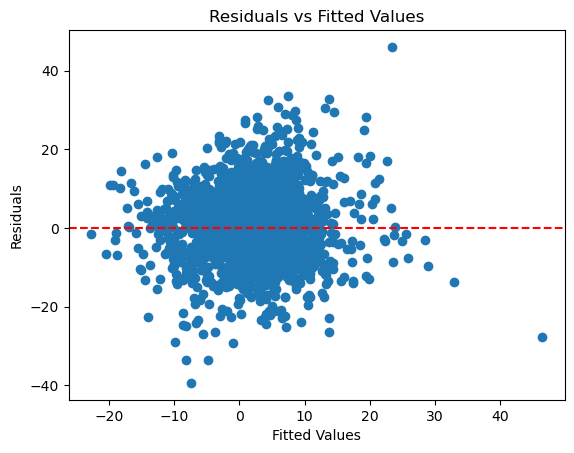

In [ ]:
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

Model assumption 3: Linearity

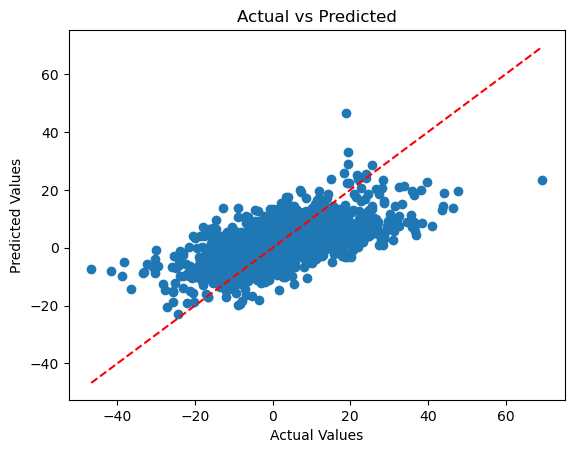

In [ ]:
y_pred = model.predict(sm.add_constant(X_train))

# Plot
plt.scatter(y_train, y_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.show()

Model assumption 4: Normality of the residuals

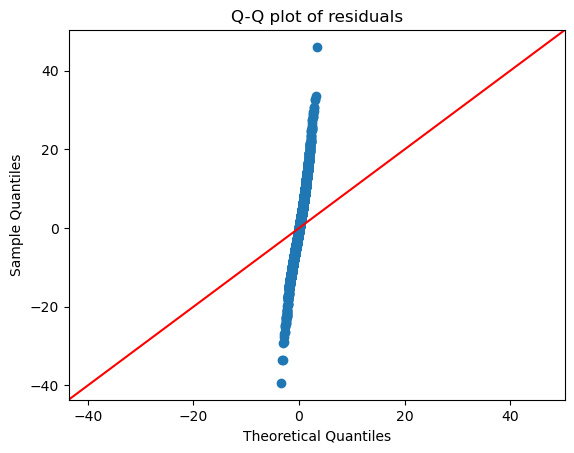

In [ ]:
sm.qqplot(model.resid, line='45')
plt.title('Q-Q plot of residuals')
plt.show()

###Checking for Autocorrelation

In [ ]:
from statsmodels.stats.stattools import durbin_watson
dw = durbin_watson(model.resid)
print(f"Durbin-Watson statistic: {dw:.4f}")

Durbin-Watson statistic: 0.4641


###Checking for Multicollinearity

In [ ]:
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                   for i in range(X_train.shape[1])]

# 3. Print
vif_data

,Variable,VIF
0,Volume,inf
1,RSI_6,58.8897
2,RSI_12,111.8900
3,EMA_14,46076.7646
4,SMA_14,23821.7044
...,...,...
222,Yield_Spread_x_SPY_Volume,2.4196
223,Gold_Price_x_ETH_Price,37.9864
224,Gold_Price_x_ETH_Volume,4.8999
225,Gold_Volume_x_ETH_Price,4.8969


Back Elimination

In [ ]:
import statsmodels.api as sm

def backward_elimination(X, y, sl=0.05, verbose=True):
    X_modeled = sm.add_constant(X)
    selected = list(X_modeled.columns)  # start with ['const', all predictors]

    while True:
        # 2) Fit model with current set of variables
        model = sm.OLS(y, X_modeled[selected]).fit()

        # 3) Examine p‐values (drop the intercept)
        pvals = model.pvalues.drop('const', errors='ignore')
        max_pval = pvals.max()

        # 4) If the worst p‐value exceeds threshold, drop that variable
        if max_pval > sl:
            worst_var = pvals.idxmax()
            selected.remove(worst_var)
            if verbose:
                print(f"Dropping '{worst_var}' (p = {max_pval:.3f})")
        else:
            break

    # 5) Re‐fit final model and return
    return selected

oklist = backward_elimination(X_train, y_train)
oklist

Dropping 'Consecutive_RSI_12_Oversold_x_Consecutive_Stochastic_Sell' (p = 0.997)
Dropping 'ATR_Ratio_x_BB_Buy' (p = 0.995)
Dropping 'ADX_Trend_Duration_x_Ascending_Triangle_Breakout_With_Volume' (p = 0.985)
Dropping 'ATR_x_BB_Buy' (p = 0.982)
Dropping 'MACD_below_signal_x_Volume_Ratio' (p = 0.980)
Dropping 'MACD_above_signal_x_Volume_Ratio' (p = 0.990)
Dropping 'MACD_Signal_x_Resistance' (p = 0.977)
Dropping 'Price_vs_MA50_x_Volume_Ratio' (p = 0.967)
Dropping 'RSI_12_Oversold_x_Stochastic_Sell_Signal' (p = 0.995)
Dropping 'RSI_12_x_Stochastic_Sell_Signal' (p = 0.965)
Dropping 'RSI_6_x_Consecutive_Stochastic_Sell' (p = 0.986)
Dropping 'MACD_buy_x_Volume' (p = 0.957)
Dropping 'MACD_below_signal_x_OBV' (p = 0.949)
Dropping 'ADX' (p = 0.941)
Dropping 'Negative_DI_x_Triangle_Duration' (p = 0.930)
Dropping 'RSI_12_Oversold_x_Consecutive_Stochastic_Buy' (p = 0.927)
Dropping 'MACD_buy_x_OBV' (p = 0.922)
Dropping 'ATR_Ratio' (p = 0.901)
Dropping 'Stop_Loss_Long' (p = 0.924)
Dropping 'Stop_Loss_

['const',
 'Volume',
 'RSI_6',
 'RSI_12',
 'OBV',
 'MACD_Signal',
 'MACD_cum_buy',
 'MACD_cum_sell',
 'BB_upper',
 'BB_lower',
 'BB_cum_Sell',
 'ATR',
 'Support',
 'Consecutive_RSI_12_Overbought',
 'MA50',
 'Price_vs_MA200',
 'MA_Distance_Ratio',
 'Volume_Ratio',
 'OBV_Slope',
 'Triangle_Completion',
 'Triangle_Height',
 'Triangle_Duration',
 'Breakout_Strength',
 'Consecutive_ADX_Buy',
 'Consecutive_ADX_Sell',
 'Gold_Volume',
 'US_10Y',
 'Yield_Spread',
 'SPY_Price',
 'ETH_Price',
 'ETH_Volume',
 'Negative_DI_x_Triangle_Completion',
 'Negative_DI_x_Triangle_Height',
 'ADX_Buy_Signal_x_Triangle_Completion',
 'ADX_Buy_Signal_x_Triangle_Duration',
 'ADX_Sell_Signal_x_Triangle_Height',
 'ADX_Strength_x_Triangle_Duration',
 'ADX_Strength_x_Triangle_Height',
 'ADX_Trend_Duration_x_Triangle_Completion',
 'ADX_x_Triangle_Duration',
 'ATR_Ratio_x_BB_cum_Buy',
 'ATR_Ratio_x_BB_lower',
 'ATR_Ratio_x_BB_upper',
 'ATR_x_BB_cum_Buy',
 'ATR_x_BB_lower',
 'ATR_x_BB_upper',
 'Consecutive_RSI_12_Overbo

In [ ]:
model_reduce = baseline_model(y_train,X_train[oklist[1:]])
print(model_reduce.summary())

                            OLS Regression Results                            
Dep. Variable:          Pct_Change_7D   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     11.27
Date:                Sun, 27 Apr 2025   Prob (F-statistic):          7.20e-130
Time:                        02:58:50   Log-Likelihood:                -8742.1
No. Observations:                2428   AIC:                         1.767e+04
Df Residuals:                    2333   BIC:                         1.822e+04
Df Model:                          94                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

PCA

In [ ]:
from scipy.stats import zscore

def stat_PCA(df, pname, n_components=None):
    # Subset and compute correlation matrix
    data = df[pname]
    corr = data.corr()

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eig(corr)
    # Sort by descending eigenvalue
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Determine number of components
    p = len(pname)
    if n_components is None or n_components > p:
        n_components = p

    # Select top n_components
    eigvecs = eigvecs[:, :n_components]

    # Compute PCA scores
    Z = data.apply(zscore)
    scores = Z.dot(eigvecs)
    scores.columns = [f'P{i+1}' for i in range(n_components)]

    # Create loadings DataFrame
    loadings = pd.DataFrame(eigvecs,
                            index=pname,
                            columns=[f'P{i+1}' for i in range(n_components)])

    return scores, loadings


In [ ]:
pcscore_train,loadings_train = stat_PCA(X_train[oklist[1:]],oklist[1:], n_components=10)
pcscore_train

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
Date,,,,,,,,,,
2015-08-07,-0.6349,3.4814,-0.8627,-0.2152,-0.0500,2.8830,-1.0560,0.8666,1.4821,-2.0890
2015-08-08,-1.1669,3.8851,-0.7221,-0.6561,-0.2468,2.2503,-1.0229,0.4940,1.4063,-2.8857
2015-08-09,-0.4918,3.5115,-0.8196,-1.0560,-0.1087,2.8852,-0.9290,0.5366,1.4773,-2.1321
2015-08-10,-0.5088,3.4890,-0.8665,-0.6113,-0.0429,2.7112,-0.9562,0.6717,1.9488,-2.3981
2015-08-11,-0.3756,3.3443,-0.8880,-0.6630,-0.2701,2.8720,-0.9882,0.9725,2.0819,-1.9464
...,...,...,...,...,...,...,...,...,...,...
2022-03-26,-1.3204,-2.5577,9.8534,-0.8256,-3.2380,8.9275,15.3741,1.6697,-5.9188,-5.1613
2022-03-27,0.3590,-4.1573,10.0303,-0.7310,-3.6754,9.6879,15.1135,-0.6222,-6.4486,-6.4111
2022-03-28,1.8714,-5.5605,10.6616,-0.7532,-4.0546,10.9196,15.7663,-2.8783,-8.0419,-8.9664


In [ ]:
loadings_train['Prop_Var_Explained'] = (loadings_train ** 2).sum(axis=1)
loadings_train

In [ ]:
model_pca = baseline_model(y_train,pcscore_train)
print(model_pca.summary())

                            OLS Regression Results                            
Dep. Variable:          Pct_Change_7D   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     9.652
Date:                Sun, 27 Apr 2025   Prob (F-statistic):           5.95e-16
Time:                        03:04:54   Log-Likelihood:                -9149.1
No. Observations:                2428   AIC:                         1.832e+04
Df Residuals:                    2417   BIC:                         1.838e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0535      0.213      9.636      0.0

Lasso/ Ridge?

##Model 2: ANN

In [ ]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

def ann_lin(x_train, y_train, x_test, y_test,
            size, max_iter=100, trace=False, n_try=5):
    best_train_mse = np.inf
    best_test_mse  = np.inf
    best_train_model = None
    best_test_model  = None

    for i in range(n_try):
        # create a regressor with one hidden layer of 'size' units
        model = MLPRegressor(hidden_layer_sizes=(size,),
                             activation='relu',
                             solver='adam',
                             max_iter=max_iter,
                             random_state=i)

        model.fit(x_train, y_train)

        # compute train MSE
        y_train_pred = model.predict(x_train)
        train_mse = mean_squared_error(y_train, y_train_pred)

        # compute test MSE
        y_test_pred = model.predict(x_test)
        test_mse = mean_squared_error(y_test, y_test_pred)

        if trace:
            print(f"Run {i+1}/{n_try} → train MSE: {train_mse:.4f}, test MSE: {test_mse:.4f}")

        # update best-by-train
        if train_mse < best_train_mse:
            best_train_mse = train_mse
            best_train_model = model

        # update best-by-test
        if test_mse < best_test_mse:
            best_test_mse = test_mse
            best_test_model = model

    return {
        'best_train_mse': best_train_mse,
        'best_test_mse':  best_test_mse,
        'best_train_model': best_train_model,
        'best_test_model':  best_test_model
    }


##Model 3: Random Forest

Decision Tree (5104)

In [ ]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Build decision tree
dt_model = DecisionTreeRegressor(max_depth=3, random_state=1)
dt_model.fit(X_train, y_train)

# Visualize decision tree
plt.figure(figsize=(18, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled=True, rounded=True, fontsize=10)
plt.title('Basic Decision Tree for Bitcoin Price', fontsize=15)
plt.tight_layout()
plt.show()

dt_val_performance = model_performance_regression(dt_model, X_val, y_val)
print("Basic Decision Tree performance:", dt_val_performance)

Random Forest

In [ ]:
# Build random forest model
regressor = RandomForestRegressor(n_estimators=100, random_state=1)
regressor.fit(X_train, y_train)


In [ ]:
# Evaluate on validation set
val_performance = model_performance_regression(regressor, X_val, y_val)
print("Validation performance:", val_performance)

###Feature Selection

In [ ]:
from sklearn.inspection import permutation_importance
# Calculate permutation importance on validation set
perm_result = permutation_importance(
    regressor, X_val, y_val,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Get importance scores and sort them
importances = perm_result.importances_mean
indices = np.argsort(importances)[::-1]  # Sort in descending order

In [ ]:
# Plot feature importances
plt.figure(figsize=(12, 8))
plt.title('Feature Importance (Permutation Method)', fontsize=15)
plt.bar(range(len(indices)), importances[indices], color='darkgreen')
plt.xticks(range(len(indices)), [X_train.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Select features with positive importance (threshold can be adjusted)
threshold = 0  # Only include features that improve predictions
selected_features = [X_train.columns[i] for i in indices if importances[i] > threshold]
print(f"Selected {len(selected_features)} out of {X_train.shape[1]} features")
print("Selected features:", selected_features)

In [ ]:
# Create datasets with only selected features
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

###Model Validation and Hyperparameter Tuning

Process time around 30 mins

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# Hyperparameter tuning
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10, 15],
    "max_features": ["sqrt", "log2", 0.8, 1],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

'''parameters = {
    "n_estimators": [110, 120],
    "max_depth": [5, 7],
    "max_features": [0.8, 1]
}'''

# Use time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Run the grid search on selected features
grid_obj = GridSearchCV(rf_tuned, parameters, scoring='r2', cv=tscv)
grid_obj.fit(X_train_selected, y_train)  # Use selected features

# Get the best model
rf_tuned_regressor = grid_obj.best_estimator_
print("Best parameters:", grid_obj.best_params_)
tuned_val_performance = model_performance_regression(rf_tuned_regressor, X_val_selected, y_val)
print("Tuned model validation performance:", tuned_val_performance)

In [ ]:
# Compare base model vs tuned model on validation
print("\nModel comparison on validation set:")
print(f"Base model R²: {val_performance['R²']:.4f}")
print(f"Tuned model R²: {tuned_val_performance['R²']:.4f}")

In [ ]:
# Train final model on combined training and validation data
X_train_val = pd.concat([X_train_selected, X_val_selected])
y_train_val = pd.concat([y_train, y_val])

final_rfmodel = RandomForestRegressor(**grid_obj.best_params_, random_state=1)
final_rfmodel.fit(X_train_val, y_train_val)

In [ ]:
# Final evaluation on test set only once
final_test_performance = model_performance_regression(final_rfmodel, X_test_selected, y_test)
print("\nFinal test performance:", final_test_performance)

In [ ]:
# Plot actual vs predicted values on test set
y_pred = final_rfmodel.predict(X_test_selected)
plt.figure(figsize=(14, 6))
plt.title('Bitcoin Price: Actual vs Predicted (Selected Features)', fontsize=15)
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linestyle='--')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Bitcoin Price % Change', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Example prediction with the model
prediction = final_rfmodel.predict(X_test_selected)[0]  #the first prediction in test set

mean_preds, lower_bounds, upper_bounds = predict_with_confidence(final_rfmodel, X_test_selected)
margin = (upper_bounds[0] - lower_bounds[0]) / 2

print(f"Predicted Bitcoin % change: {mean_preds[0]:.2f}% ± {margin:.2f}% with 95% confidence")

#Model 4: Logistic Regression for 5104

In [ ]:
# Stepwise regression function
def stepwise_logistic_regression(X, y, initial_features=None, p_value_threshold=0.05,
                               direction='forward', max_iterations=50, max_features=15):

    all_features = X.columns.tolist()

    # Start with empty list for forward selection
    current_features = [] if initial_features is None else [f for f in initial_features if f in all_features]

    # Add constant for statsmodels
    X_with_const = sm.add_constant(X)

    # Initialize variables
    best_features = current_features.copy()
    iterations_log = []
    iteration = 0
    improved = True
    best_aic = float('inf')
    best_model = None

    print(f"Starting with {len(current_features)} features")
    if current_features:
        print(f"Initial features: {current_features}")

    # Start stepwise selection
    while improved and iteration < max_iterations and len(current_features) < max_features:
        improved = False
        iteration += 1
        print(f"\nIteration {iteration}:")

        # Define candidate features for forward selection
        forward_candidates = [f for f in all_features if f not in current_features]

        # Try adding one feature (forward selection)
        best_forward_feature = None
        best_forward_aic = float('inf')

        if direction in ['forward', 'both']:
            for feature in forward_candidates:
                candidate_features = current_features + [feature]
                try:
                    # Prepare features including constant
                    X_subset = X_with_const[['const'] + candidate_features]

                    # Fit model and get AIC
                    try:
                        model = sm.Logit(y, X_subset).fit(disp=0, method='lbfgs', maxiter=200)
                    except:
                        model = sm.Logit(y, X_subset).fit(disp=0, method='bfgs', maxiter=200)

                    aic = model.aic

                    # Check if p-value for the newly added feature is significant
                    p_value = model.pvalues.get(feature, 1.0)

                    if p_value <= p_value_threshold and aic < best_forward_aic:
                        best_forward_aic = aic
                        best_forward_feature = feature
                        best_forward_model = model
                        print(f"  Testing adding {feature}: AIC={aic:.2f}, p-value={p_value:.4f}")
                except Exception as e:
                    print(f"  Error testing {feature}: {str(e)[:60]}...")
                    continue

        # Check if we can add the feature
        if best_forward_feature and (best_forward_aic < best_aic):
            # Add the best feature
            print(f"Adding feature: {best_forward_feature}, AIC: {best_forward_aic:.2f}")
            current_features.append(best_forward_feature)
            best_aic = best_forward_aic
            best_model = best_forward_model
            improved = True
            iterations_log.append({
                'iteration': iteration,
                'action': 'add',
                'feature': best_forward_feature,
                'aic': best_forward_aic,
                'features': current_features.copy()
            })

        # If direction includes backward, check for insignificant features to remove
        if direction in ['backward', 'both'] and len(current_features) > 1 and best_model is not None:
            # Get p-values for all features
            p_values = {col: best_model.pvalues.get(col, 1.0) for col in current_features}

            # Find the most insignificant feature (if any)
            insignificant_features = [f for f in current_features if p_values.get(f, 0) > p_value_threshold]

            if insignificant_features:
                # Sort by p-value (most insignificant first)
                insignificant_features.sort(key=lambda f: p_values.get(f, 0), reverse=True)

                # Remove the most insignificant feature and refit
                feature_to_remove = insignificant_features[0]
                candidate_features = [f for f in current_features if f != feature_to_remove]

                try:
                    # Prepare features including constant
                    X_subset = X_with_const[['const'] + candidate_features]

                    # Fit model and get AIC
                    model = sm.Logit(y, X_subset).fit(disp=0, method='lbfgs', maxiter=200)
                    aic = model.aic

                    print(f"Testing removal of {feature_to_remove}: AIC={aic:.2f}, p-value={p_values.get(feature_to_remove, 1):.4f}")

                    # If removing improves AIC, remove it
                    if aic < best_aic:
                        print(f"Removing feature: {feature_to_remove}, AIC: {aic:.2f}")
                        current_features = candidate_features
                        best_aic = aic
                        best_model = model
                        improved = True
                        iterations_log.append({
                            'iteration': iteration,
                            'action': 'remove',
                            'feature': feature_to_remove,
                            'aic': aic,
                            'features': current_features.copy()
                        })
                except Exception as e:
                    print(f"Error removing {feature_to_remove}: {str(e)[:60]}...")

        # Update best features if improved
        if improved:
            best_features = current_features.copy()

        print(f"Current features ({len(current_features)}): {current_features}")
        print(f"Current AIC: {best_aic:.2f}")

    # Final model with best features
    if best_features:
        try:
            X_final = X_with_const[['const'] + best_features]
            final_model = sm.Logit(y, X_final).fit(disp=0, method='lbfgs', maxiter=200)
            return best_features, final_model, iterations_log
        except Exception as e:
            print(f"Error fitting final model: {str(e)}")
            return best_features, best_model, iterations_log

    return [], None, iterations_log


In [ ]:
# Calculate comprehensive metrics
def cal_metrics(y_actual, y_pred):
    """Calculate all classification metrics from confusion matrix"""
    cm = confusion_matrix(y_actual, y_pred)
    tn, fp, fn, tp = cm.ravel()

    metrics = {}
    metrics['Accuracy'] = (tp+tn)/(tp+tn+fp+fn)
    metrics['Recall'] = tp/(tp+fn) if (tp+fn) > 0 else 0
    metrics['Specificity'] = tn/(tn+fp) if (tn+fp) > 0 else 0
    metrics['Precision'] = tp/(tp+fp) if (tp+fp) > 0 else 0
    metrics['False_Positive_Rate'] = fp/(fp+tn) if (fp+tn) > 0 else 0
    metrics['False_Negative_Rate'] = fn/(fn+tp) if (fn+tp) > 0 else 0
    metrics['Error_Rate'] = (fp+fn)/(tp+tn+fp+fn)
    metrics['F1_Score'] = 2*tp/(2*tp+fp+fn) if (2*tp+fp+fn) > 0 else 0

    return metrics

In [ ]:
# Build stepwise logistic regression
start_time = time.time()

initial_features = []  # Start with empty set

# Run stepwise regression
final_features, final_model, iterations_log = stepwise_logistic_regression(
    X_train,
    y_train,
    initial_features=initial_features,
    p_value_threshold=0.05,
    direction='both',  # Use both forward and backward steps
    max_iterations=50,
    max_features=15   # Limit to 15 features max
)

elapsed_time = time.time() - start_time
print(f"\nStepwise regression completed in {elapsed_time:.2f} seconds")
print(f"Selected {len(final_features)} features out of {len(X_train.columns)} candidates")
print("Selected features:", final_features)

# Visualize the feature selection process
iterations_df = pd.DataFrame(iterations_log)
if not iterations_df.empty:
    plt.figure(figsize=(12, 6))
    plt.plot(iterations_df['iteration'], iterations_df['aic'], 'o-', color='blue')
    plt.xlabel('Iteration')
    plt.ylabel('AIC Score')
    plt.title('AIC Score Improvement During Stepwise Selection')
    plt.grid(True, alpha=0.3)

    # Annotate add/remove actions
    for i, row in iterations_df.iterrows():
        action_color = 'green' if row['action'] == 'add' else 'red'
        plt.annotate(
            f"{row['action']}: {row['feature'][:15]}",
            (row['iteration'], row['aic']),
            textcoords="offset points",
            xytext=(0, 10 if i % 2 == 0 else -20),
            ha='center',
            color=action_color,
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

# Feature importance from the final model
if final_model is not None:
    # Get model coefficients (excluding constant)
    coefficients = final_model.params.drop('const', errors='ignore')

    # Calculate odds ratios and confidence intervals
    conf_int = final_model.conf_int()
    odds_ratios = np.exp(coefficients)
    odds_ratios_ci = np.exp(conf_int.drop('const', errors='ignore'))

    # Create a DataFrame with the results
    feature_importance = pd.DataFrame({
        'Feature': coefficients.index,
        'Coefficient': coefficients.values,
        'Odds_Ratio': odds_ratios.values,
        'CI_Lower': odds_ratios_ci[0].values,
        'CI_Upper': odds_ratios_ci[1].values,
        'P_Value': final_model.pvalues.drop('const', errors='ignore').values
    })

    # Sort by absolute coefficient value
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

    # Plot feature importance
    plt.figure(figsize=(12, max(8, len(feature_importance) * 0.3)))

    # Color based on positive/negative impact
    colors = ['green' if c > 0 else 'red' for c in feature_importance['Coefficient']]

    # Create the bar plot
    plt.barh(
        feature_importance['Feature'],
        feature_importance['Coefficient'],
        color=colors
    )

    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title('Feature Importance for Bitcoin Price Direction')
    plt.xlabel('Coefficient (Log Odds)')
    plt.ylabel('Feature')
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print detailed feature importance table
    print("\nFeature Importance:")
    pd.set_option('display.max_rows', None)
    print(feature_importance[['Feature', 'Coefficient', 'Odds_Ratio', 'P_Value', 'CI_Lower', 'CI_Upper']])

    # Print model summary
    print("\nFinal Model Summary:")
    print(final_model.summary())

In [ ]:
# Evaluate on validation set
print("\nEvaluating on validation set...")

# Add constant for predictions
X_val_selected = sm.add_constant(X_val[final_features])

# Get validation predictions
val_probs = final_model.predict(X_val_selected)
val_preds = (val_probs >= 0.5).astype(int)

# Calculate detailed validation metrics
val_metrics = cal_metrics(y_val, val_preds)
val_auc = roc_auc_score(y_val, val_probs)

print("\nValidation Set Performance:")
print(f"Accuracy: {val_metrics['Accuracy']:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"Recall (Sensitivity): {val_metrics['Recall']:.4f}")
print(f"Specificity: {val_metrics['Specificity']:.4f}")
print(f"Precision: {val_metrics['Precision']:.4f}")
print(f"F1 Score: {val_metrics['F1_Score']:.4f}")
print(f"False Negative Rate: {val_metrics['False_Negative_Rate']:.4f}")
print(f"Error Rate: {val_metrics['Error_Rate']:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, val_preds))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, val_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Validation)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Decrease/No Change', 'Increase'])
plt.yticks([0.5, 1.5], ['Decrease/No Change', 'Increase'])
plt.tight_layout()
plt.show()

# Find optimal threshold
print("\nFinding optimal threshold...")
# Calculate metrics at different thresholds
thresholds = np.arange(0.01, 1, 0.01)
accuracy_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
specificity_scores = []

for threshold in thresholds:
    y_pred = (val_probs >= threshold).astype(int)
    metrics = cal_metrics(y_val, y_pred)
    accuracy_scores.append(metrics['Accuracy'])
    f1_scores.append(metrics['F1_Score'])
    precision_scores.append(metrics['Precision'])
    recall_scores.append(metrics['Recall'])
    specificity_scores.append(metrics['Specificity'])

# Plot metrics vs threshold
plt.figure(figsize=(12, 8))
plt.plot(thresholds, accuracy_scores, 'b-', label='Accuracy')
plt.plot(thresholds, f1_scores, 'g-', label='F1 Score')
plt.plot(thresholds, precision_scores, 'r-', label='Precision')
plt.plot(thresholds, recall_scores, 'y-', label='Recall (Sensitivity)')
plt.plot(thresholds, specificity_scores, 'm-', label='Specificity')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Threshold')
plt.grid(True, alpha=0.3)
plt.legend()

# Find optimal thresholds for different metrics
opt_acc_threshold = thresholds[np.argmax(accuracy_scores)]
opt_f1_threshold = thresholds[np.argmax(f1_scores)]

# Find threshold where precision and recall are closest (balanced)
pr_diff = np.abs(np.array(precision_scores) - np.array(recall_scores))
opt_pr_threshold = thresholds[np.argmin(pr_diff)]

plt.axvline(x=0.5, color='grey', linestyle='--', label='Default (0.5)')
plt.axvline(x=opt_acc_threshold, color='blue', linestyle='--',
            label=f'Optimal Accuracy ({opt_acc_threshold:.2f})')
plt.axvline(x=opt_f1_threshold, color='green', linestyle='--',
            label=f'Optimal F1 ({opt_f1_threshold:.2f})')
plt.axvline(x=opt_pr_threshold, color='purple', linestyle='--',
            label=f'Balanced P-R ({opt_pr_threshold:.2f})')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal threshold for accuracy: {opt_acc_threshold:.2f}")
print(f"Optimal threshold for F1 score: {opt_f1_threshold:.2f}")
print(f"Balanced precision-recall threshold: {opt_pr_threshold:.2f}")

# Choose the threshold to use (you might prefer F1 for imbalanced data)
chosen_threshold = opt_f1_threshold
print(f"Using threshold: {chosen_threshold:.2f}")

In [ ]:
# Retrain on combined train+validation data with selected features
print("\nRetraining on combined training and validation data...")
X_train_val = pd.concat([X_train[final_features], X_val[final_features]])
y_train_val = pd.concat([y_train, y_val])

# Add constant for statsmodels
X_train_val_sm = sm.add_constant(X_train_val)

# Fit final statsmodels model
try:
    final_combined_model = sm.Logit(y_train_val, X_train_val_sm).fit(
        disp=0,
        method='lbfgs',
        maxiter=200
    )
    print("\nFinal Combined Model Summary:")
    print(final_combined_model.summary())
except Exception as e:
    print(f"Error fitting combined model: {str(e)}")
    print("Using original model instead")
    final_combined_model = final_model

In [ ]:
# Evaluate on test set
print("\nEvaluating on test set...")

# Add constant for predictions
X_test_selected = sm.add_constant(X_test[final_features])

# Get test predictions
test_probs = final_combined_model.predict(X_test_selected)
test_preds = (test_probs >= chosen_threshold).astype(int)

# Calculate detailed test metrics
test_metrics = cal_metrics(y_test, test_preds)
test_auc = roc_auc_score(y_test, test_probs)

print("\nTest Set Performance:")
print(f"Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Recall (Sensitivity): {test_metrics['Recall']:.4f}")
print(f"Specificity: {test_metrics['Specificity']:.4f}")
print(f"Precision: {test_metrics['Precision']:.4f}")
print(f"F1 Score: {test_metrics['F1_Score']:.4f}")
print(f"False Negative Rate: {test_metrics['False_Negative_Rate']:.4f}")
print(f"Error Rate: {test_metrics['Error_Rate']:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))

# Plot confusion matrix for test set
plt.figure(figsize=(8, 6))
cm_test = confusion_matrix(y_test, test_preds)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks([0.5, 1.5], ['Decrease/No Change', 'Increase'])
plt.yticks([0.5, 1.5], ['Decrease/No Change', 'Increase'])
plt.tight_layout()
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Bitcoin Price Direction Prediction')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Print comprehensive final summary
print("\n===== FINAL MODEL SUMMARY =====")
print(f"Selected {len(final_features)} features: {final_features}")

print("\nValidation Performance:")
print(f"Accuracy: {val_metrics['Accuracy']:.4f}")
print(f"AUC: {val_auc:.4f}")
print(f"Precision: {val_metrics['Precision']:.4f}")
print(f"Recall (Sensitivity): {val_metrics['Recall']:.4f}")
print(f"Specificity: {val_metrics['Specificity']:.4f}")
print(f"F1 Score: {val_metrics['F1_Score']:.4f}")
print(f"False Negative Rate: {val_metrics['False_Negative_Rate']:.4f}")
print(f"Error Rate: {val_metrics['Error_Rate']:.4f}")

print("\nTest Performance:")
print(f"Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"AUC: {test_auc:.4f}")
print(f"Precision: {test_metrics['Precision']:.4f}")
print(f"Recall (Sensitivity): {test_metrics['Recall']:.4f}")
print(f"Specificity: {test_metrics['Specificity']:.4f}")
print(f"F1 Score: {test_metrics['F1_Score']:.4f}")
print(f"False Negative Rate: {test_metrics['False_Negative_Rate']:.4f}")
print(f"Error Rate: {test_metrics['Error_Rate']:.4f}")

print(f"\nOptimal threshold: {chosen_threshold:.2f}")
print("===============================")

#Model Performance Comparison

In [ ]:
# RMSE
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())


# MAPE
def mape(predictions, targets):
    return np.mean(np.abs((targets - predictions)) / targets) * 100


# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(olsmodel, x_train, x_test, y_train, y_test):

    # Insample Prediction
    y_pred_train = olsmodel.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = olsmodel.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
                "MAPE": [
                    mape(y_pred_train, y_observed_train),
                    mape(y_pred_test, y_observed_test),
                ],
            }
        )
    )

# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [ ]:
# Linear regression model
lin_reg_test = model_performance_regression(olsmodel1, X_test, y_test)
lin_reg_test

model_pref(olsmodel1, X_train, X_test,y_train,y_test)

In [ ]:
# ANN

In [ ]:
# Random Forest
regressor_perf_test = model_performance_regression(regressor, X_test, y_test)

regressor_perf_test

In [ ]:
# Tuned Random Forest Regressor
rf_tuned_regressor_perf_test = model_performance_regression(rf_tuned_regressor, X_test_selected, y_test)

rf_tuned_regressor_perf_test

In [ ]:
models_test_comp_df = pd.concat(
    [
        lin_reg_test.T,
        regressor_perf_test.T,
        rf_tuned_regressor_perf_test.T
    ],
    axis=1,
)

models_test_comp_df.columns = [
    "Linear Regression",
    "Random Forest regressor",
    "Tuned Random Forest Regressor"]

print("Test performance comparison:")
models_test_comp_df

#Final Model Evaluation and Backtesting

In [ ]:
final_model = # pending
final_model.fit(x_train, y_train)

final_model_perf_train = model_performance_regression(final_model, x_train, y_train)

final_model_perf_train

final_model_test_perf = model_performance_regression(final_model, x_test, y_test)
print("Test Performance:")
final_model_test_perf

## Back Transformation After prediction (for interpretation)

In [ ]:
# Recreate PowerTransformers with stored lambdas for back-transformation
power_transformer_price.lambdas_ = [lambdas['Price_lambda']]
power_transformer_change.lambdas_ = [lambdas['Change_lambda']]
power_transformer_7d_pct_change.lambdas_ = [lambdas['Pct_Change_lambda_7D']]
power_transformer_2d_pct_change.lambdas_ = [lambdas['Pct_Change_lambda_2D']]

# Step 1: De-standardize the standardized values to get Yeo-Johnson transformed values
scaled_btc_data['YeoJohnson_Price_Back'] = (
    scaled_btc_data['YeoJohnson_Price'] * transformed_stds['Price_std']
) + transformed_means['Price_mean']

scaled_btc_data['YeoJohnson_Change_Back'] = (
    scaled_btc_data['YeoJohnson_Change'] * transformed_stds['Change_std']
) + transformed_means['Change_mean']

scaled_btc_data['YeoJohnson_7D_Pct_Change_Back'] = (
    scaled_btc_data['YeoJohnson_7D_Pct_Change'] * transformed_stds['Pct_Change_std_7D']
) + transformed_means['Pct_Change_mean_7D']

scaled_btc_data['YeoJohnson_2D_Pct_Change_Back'] = (
    scaled_btc_data['YeoJohnson_2D_Pct_Change'] * transformed_stds['Pct_Change_std_2D']
) + transformed_means['Pct_Change_mean_2D']

# Step 2: Create temporary DataFrames with the exact column names used during fit
price_back_df = scaled_btc_data[['YeoJohnson_Price_Back']].rename(columns={'YeoJohnson_Price_Back': 'Price'})
change_back_df = scaled_btc_data[['YeoJohnson_Change_Back']].rename(columns={'YeoJohnson_Change_Back': 'Change'})
pct_change_7d_back_df = scaled_btc_data[['YeoJohnson_7D_Pct_Change_Back']].rename(columns={'YeoJohnson_7D_Pct_Change_Back': 'Pct_Change_7D'})
pct_change_2d_back_df = scaled_btc_data[['YeoJohnson_2D_Pct_Change_Back']].rename(columns={'YeoJohnson_2D_Pct_Change_Back': 'Pct_Change_2D'})

# Step 3: Apply the inverse transformation to recover the original values
scaled_btc_data['Original_Price'] = power_transformer_price.inverse_transform(price_back_df)
scaled_btc_data['Original_Change'] = power_transformer_change.inverse_transform(change_back_df)
scaled_btc_data['Original_7D_Pct_Change'] = power_transformer_7d_pct_change.inverse_transform(pct_change_7d_back_df)
scaled_btc_data['Original_2D_Pct_Change'] = power_transformer_2d_pct_change.inverse_transform(pct_change_2d_back_df)

# Step 4: Display the back-transformed data
print("\nBack-Transformed Data:")
print(scaled_btc_data[['Original_Price', 'Original_Change', 'Original_7D_Pct_Change', 'Original_2D_Pct_Change']].head())

## Backtesting and Trading Strategy

current model: tuned_rf

In [ ]:
from tqdm import tqdm

In [ ]:
# 1. Prediction Engine - generates predictions only
def generate_predictions(model, X, target_col, test_size=0.3, step_size=0.05):
    """Generate predictions using walk-forward validation"""
    # Extract features and target
    feature_cols = [col for col in X.columns if not any(x in col for x in ['YeoJohnson_', 'Original_'])]
    X_features = X[feature_cols].copy()
    target_series = X[target_col].copy()

    # Calculate indices
    data_size = len(X_features)
    test_start_idx = int(data_size * (1 - test_size))
    step_idx = max(1, int(data_size * step_size))

    # Create results DataFrame
    results = pd.DataFrame(index=X_features.index[test_start_idx:])
    results['actual'] = target_series.iloc[test_start_idx:].values
    results['predicted'] = np.nan

    # Add price if available
    if 'Original_Price' in X.columns:
        results['price'] = X['Original_Price'].iloc[test_start_idx:].values

    # Walk-forward testing
    train_end_idx = test_start_idx
    with tqdm(total=data_size - test_start_idx) as pbar:
        while train_end_idx < data_size:
            # Define train set and prediction window
            X_train = X_features.iloc[:train_end_idx]
            y_train = target_series.iloc[:train_end_idx]
            pred_end_idx = min(train_end_idx + step_idx, data_size)
            X_pred = X_features.iloc[train_end_idx:pred_end_idx]

            if len(X_pred) == 0:
                break

            # Train model and predict
            model_clone = RandomForestRegressor(**model.get_params())
            model_clone.fit(X_train, y_train)
            predictions = model_clone.predict(X_pred)

            # Store predictions
            pred_indices = X_features.index[train_end_idx:pred_end_idx]
            results.loc[pred_indices, 'predicted'] = predictions

            # Move forward
            train_end_idx = pred_end_idx
            pbar.update(min(step_idx, pred_end_idx - (train_end_idx - step_idx)))

    # Calculate metrics
    mse = mean_squared_error(results['actual'].dropna(), results['predicted'].dropna())
    rmse = np.sqrt(mse)
    r2 = r2_score(results['actual'].dropna(), results['predicted'].dropna())

    print(f"Prediction Metrics: MSE={mse:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}")

    return results

In [ ]:
# 2. Trading Strategy - applies trading logic
def apply_trading_strategy(prediction_results, target_col,
                          initial_capital=10000, position_size=0.95,
                          stop_loss=None, take_profit=None):
    """Apply trading strategy to predictions"""
    results = prediction_results.copy()

    # Create signal: 1 for buy (predicted > 0), -1 for sell (predicted < 0)
    results['signal'] = np.sign(results['predicted'])

    # Calculate actual returns based on target type
    if '7D_Pct_Change' in target_col or '2D_Pct_Change' in target_col:
        results['actual_return'] = results['actual'] / 100  # Convert % to decimal
    else:
        # For price or change targets
        if 'price' in results.columns:
            results['actual_return'] = results['price'].pct_change()
        else:
            results['actual_return'] = results['actual']

    # Shift signal to avoid look-ahead bias
    results['signal'] = results['signal'].shift(1)
    results['signal'].iloc[0] = 0  # No position on first day

    # Portfolio simulation
    results['capital'] = initial_capital
    results['position'] = 0
    results['shares'] = 0
    results['cash'] = initial_capital

    # Set up for price tracking
    if 'price' in results.columns:
        price_col = 'price'
    else:
        # Create synthetic price starting at 100
        results['synth_price'] = 100
        for i in range(1, len(results)):
            results['synth_price'].iloc[i] = results['synth_price'].iloc[i-1] * (1 + results['actual_return'].iloc[i])
        price_col = 'synth_price'

    # Implement trading logic
    entry_price = 0
    current_position = 0

    for i in range(1, len(results)):
        prev_idx = results.index[i-1]
        curr_idx = results.index[i]

        # Get values from previous day
        prev_signal = results.loc[prev_idx, 'signal']
        prev_cash = results.loc[prev_idx, 'cash']
        prev_shares = results.loc[prev_idx, 'shares']

        # Current price
        curr_price = results.loc[curr_idx, price_col]

        # Check stop-loss/take-profit
        if current_position != 0 and entry_price > 0:
            if current_position == 1:  # Long position
                current_return = (curr_price / entry_price) - 1
                # Stop loss
                if stop_loss is not None and current_return <= -stop_loss:
                    cash_value = prev_shares * curr_price
                    current_position = 0
                    entry_price = 0
                    prev_signal = 0
                    prev_cash = cash_value
                    prev_shares = 0
                # Take profit
                elif take_profit is not None and current_return >= take_profit:
                    cash_value = prev_shares * curr_price
                    current_position = 0
                    entry_price = 0
                    prev_signal = 0
                    prev_cash = cash_value
                    prev_shares = 0

            elif current_position == -1:  # Short position
                current_return = 1 - (curr_price / entry_price)
                # Stop loss
                if stop_loss is not None and current_return <= -stop_loss:
                    cash_value = prev_cash + (entry_price - curr_price) * abs(prev_shares)
                    current_position = 0
                    entry_price = 0
                    prev_signal = 0
                    prev_cash = cash_value
                    prev_shares = 0
                # Take profit
                elif take_profit is not None and current_return >= take_profit:
                    cash_value = prev_cash + (entry_price - curr_price) * abs(prev_shares)
                    current_position = 0
                    entry_price = 0
                    prev_signal = 0
                    prev_cash = cash_value
                    prev_shares = 0

        # Process trading signal if different from current position
        if prev_signal != current_position:
            # Close existing position
            if current_position == 1:  # Close long
                cash_value = prev_shares * curr_price
                prev_cash = cash_value
                prev_shares = 0
            elif current_position == -1:  # Close short
                cash_value = prev_cash + (entry_price - curr_price) * abs(prev_shares)
                prev_cash = cash_value
                prev_shares = 0

            # Open new position
            if prev_signal != 0:
                position_value = prev_cash * position_size

                if prev_signal == 1:  # Long
                    prev_shares = position_value / curr_price
                    prev_cash -= position_value
                    current_position = 1
                    entry_price = curr_price
                elif prev_signal == -1:  # Short
                    prev_shares = -position_value / curr_price
                    current_position = -1
                    entry_price = curr_price

        # Calculate current capital
        if current_position == 1:  # Long
            curr_capital = prev_cash + (prev_shares * curr_price)
        elif current_position == -1:  # Short
            short_pnl = (entry_price - curr_price) * abs(prev_shares)
            curr_capital = prev_cash + short_pnl
        else:  # No position
            curr_capital = prev_cash

        # Update results
        results.loc[curr_idx, 'capital'] = curr_capital
        results.loc[curr_idx, 'position'] = current_position
        results.loc[curr_idx, 'shares'] = prev_shares
        results.loc[curr_idx, 'cash'] = prev_cash

    # Calculate performance metrics
    results['daily_return'] = results['capital'].pct_change()
    results['cum_return'] = (1 + results['daily_return']).cumprod() - 1

    # Market returns (buy & hold)
    results['market_return'] = results[price_col].pct_change()
    results['cum_market_return'] = (1 + results['market_return']).cumprod() - 1

    # Calculate drawdowns
    results['peak_capital'] = results['capital'].cummax()
    results['drawdown'] = (results['capital'] - results['peak_capital']) / results['peak_capital']

    return results


In [ ]:
# 3. Performance Analysis - calculates and displays performance
def analyze_backtest(backtest_results):
    """Calculate performance metrics and display results"""
    results = backtest_results.copy()

    # Calculate basic metrics
    total_return = results['cum_return'].iloc[-1]
    market_return = results['cum_market_return'].iloc[-1]
    max_drawdown = results['drawdown'].min()

    # Calculate annualized return
    days = (results.index[-1] - results.index[0]).days
    years = max(days / 365, 0.01)
    annual_return = (1 + total_return) ** (1/years) - 1
    market_annual = (1 + market_return) ** (1/years) - 1

    # Calculate Sharpe ratio (annualized)
    risk_free_rate = 0.02  # 2% annual risk-free rate
    excess_returns = results['daily_return'] - ((1 + risk_free_rate) ** (1/252) - 1)
    sharpe_ratio = np.sqrt(252) * excess_returns.mean() / excess_returns.std() if excess_returns.std() > 0 else 0

    # Calculate win rate and trades
    trade_changes = results['position'].diff().fillna(0)
    total_trades = (trade_changes != 0).sum() / 2
    winning_days = (results['daily_return'] > 0).sum()
    losing_days = (results['daily_return'] < 0).sum()
    win_rate = winning_days / (winning_days + losing_days) if (winning_days + losing_days) > 0 else 0

    # Print results
    print("\nPerformance Summary:")
    print(f"Total Return: {total_return:.2%} (Market: {market_return:.2%})")
    print(f"Annual Return: {annual_return:.2%} (Market: {market_annual:.2%})")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    print(f"Total Trades: {total_trades:.0f}")
    print(f"Win Rate: {win_rate:.2%} ({winning_days}/{winning_days+losing_days})")

    return {
        'total_return': total_return,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'total_trades': total_trades,
        'win_rate': win_rate
    }


In [ ]:
# 4. Visualization - creates plots
def visualize_backtest(backtest_results, target_col):
    """Create visualization of backtest results"""
    results = backtest_results.copy()

    # Plot 1: Actual vs Predicted
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['actual'], 'b-', label='Actual')
    plt.plot(results.index, results['predicted'], 'r-', label='Predicted')

    if '7D_Pct_Change' in target_col:
        title = '7-Day Percentage Change'
        ylabel = '7-Day % Change'
    elif '2D_Pct_Change' in target_col:
        title = '2-Day Percentage Change'
        ylabel = '2-Day % Change'
    else:
        title = 'Value'
        ylabel = 'Value'

    plt.title(f'Actual vs Predicted {title}')
    plt.xlabel('Date')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 2: Capital Growth
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['capital'], 'g-', label='Strategy Capital')

    # Add buy-and-hold for comparison
    price_col = 'price' if 'price' in results.columns else 'synth_price'
    initial_capital = results['capital'].iloc[0]
    initial_price = results[price_col].iloc[0]
    initial_shares = initial_capital / initial_price
    buy_hold_capital = initial_shares * results[price_col]
    plt.plot(results.index, buy_hold_capital, 'b-', label='Buy & Hold')

    plt.title('Capital Growth')
    plt.xlabel('Date')
    plt.ylabel('Capital ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 3: Cumulative Returns
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['cum_return'], 'g-', label='Strategy')
    plt.plot(results.index, results['cum_market_return'], 'b-', label='Market')
    plt.title('Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 4: Drawdowns
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['drawdown'], 'r-')
    plt.title('Strategy Drawdowns')
    plt.xlabel('Date')
    plt.ylabel('Drawdown')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 5: Position over time
    plt.figure(figsize=(12, 6))
    plt.plot(results.index, results['position'], 'b-')
    plt.title('Position Over Time')
    plt.xlabel('Date')
    plt.ylabel('Position (1=Long, -1=Short, 0=Cash)')
    plt.yticks([-1, 0, 1])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# 5. Main function - runs everything
def backtest_model(model, X, target_col='Original_7D_Pct_Change',
                  test_size=0.3, step_size=0.05,
                  initial_capital=10000, position_size=0.95,
                  stop_loss=None, take_profit=None,
                  plot=True):
    """Main function to run backtest with model predictions"""

    # Step 1: Generate predictions
    print("Step 1: Generating predictions...")
    prediction_results = generate_predictions(
        model=model, X=X, target_col=target_col,
        test_size=test_size, step_size=step_size
    )

    # Step 2: Apply trading strategy
    print("\nStep 2: Applying trading strategy...")
    backtest_results = apply_trading_strategy(
        prediction_results=prediction_results,
        target_col=target_col,
        initial_capital=initial_capital,
        position_size=position_size,
        stop_loss=stop_loss,
        take_profit=take_profit
    )

    # Step 3: Analyze results
    print("\nStep 3: Analyzing performance...")
    performance = analyze_backtest(backtest_results)

    # Step 4: Visualize results
    if plot:
        print("\nStep 4: Generating visualizations...")
        visualize_backtest(backtest_results, target_col)

    return backtest_results, performance

# Example usage
backtest_results, performance = backtest_model(
    model=rf_tuned_regressor,
    X=scaled_btc_data,
    target_col='Original_7D_Pct_Change',
    test_size=0.3,
    step_size=0.05,
    initial_capital=10000,
    position_size=0.95,
    stop_loss=0.05,
    take_profit=0.05,
    plot=True
)

##Predicting % of Bitcoin Price Change in 7 Days

In [ ]:
def predict_future_bitcoin_change(model, current_data, confidence_level=0.95):
    """
    Predict the 7-day percentage change in Bitcoin price from today.

    Parameters:
    -----------
    model : trained model
        The trained prediction model
    current_data : DataFrame
        Contains the latest feature values
    confidence_level : float
        Confidence level for prediction intervals
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    # Extract only features the model was trained with
    if hasattr(model, 'feature_names_in_'):
        model_features = list(model.feature_names_in_)
    else:
        model_features = [col for col in current_data.columns
                          if not any(x in col for x in ['YeoJohnson_', 'Original_'])]

    # Get current date and price
    current_date = current_data.index[-1]
    current_price = current_data['Original_Price'].iloc[-1] if 'Original_Price' in current_data.columns else None
    target_date = current_date + pd.Timedelta(days=7)

    # Make prediction
    latest_features = current_data[model_features].iloc[-1:].copy()
    prediction = model.predict(latest_features)[0]

    # Calculate confidence interval (for RandomForest models)
    if hasattr(model, 'estimators_'):
        tree_predictions = [tree.predict(latest_features)[0] for tree in model.estimators_]
        alpha = 1 - confidence_level
        lower_bound = np.percentile(tree_predictions, (alpha/2)*100)
        upper_bound = np.percentile(tree_predictions, (1-alpha/2)*100)
        std_dev = np.std(tree_predictions)
    else:
        std_dev = abs(prediction) * 0.2
        lower_bound = prediction - 1.96 * std_dev
        upper_bound = prediction + 1.96 * std_dev

    # Determine signal
    if prediction > 2.0:
        signal = "BUY"
    elif prediction > 0:
        signal = "WEAK BUY"
    elif prediction < -2.0:
        signal = "SELL"
    elif prediction < 0:
        signal = "WEAK SELL"
    else:
        signal = "NEUTRAL"

    # Calculate price targets if price data is available
    if current_price:
        predicted_price = current_price * (1 + prediction/100)
        lower_price = current_price * (1 + lower_bound/100)
        upper_price = current_price * (1 + upper_bound/100)

        # Calculate stop loss and take profit
        if signal in ["BUY", "WEAK BUY"]:
            stop_loss = current_price * 0.95
            take_profit = current_price * (1 + max(prediction/100 * 1.5, 0.1))
        elif signal in ["SELL", "WEAK SELL"]:
            stop_loss = current_price * 1.05
            take_profit = current_price * (1 + min(prediction/100 * 1.5, -0.1))
        else:
            stop_loss = take_profit = None

    # Display results
    print(f"\n{'='*60}")
    print(f"BITCOIN 7-DAY PRICE PREDICTION ({confidence_level*100:.0f}% CONFIDENCE)")
    print(f"{'='*60}")
    print(f"Current Date: {current_date.strftime('%Y-%m-%d')}")
    print(f"Target Date:  {target_date.strftime('%Y-%m-%d')}")

    if current_price:
        print(f"\nCurrent Price: ${current_price:,.2f}")
        print(f"Predicted Price: ${predicted_price:,.2f}")
        print(f"Price Range: ${lower_price:,.2f} to ${upper_price:,.2f}")

    print(f"\nPredicted 7-Day Change: {prediction:.2f}%")
    print(f"Range: {lower_bound:.2f}% to {upper_bound:.2f}%")
    print(f"\nSIGNAL: {signal}")

    # Show trading advice
    print("\nTrading Advice:", end=" ")
    if signal == "BUY":
        print("Strong buying opportunity.")
        if current_price:
            print(f"Stop Loss: ${stop_loss:,.2f} (-5.00%)")
            print(f"Take Profit: ${take_profit:,.2f} (+{(take_profit/current_price-1)*100:.2f}%)")
    elif signal == "WEAK BUY":
        print("Mild bullish signal.")
    elif signal == "SELL":
        print("Strong selling opportunity.")
        if current_price:
            print(f"Stop Loss: ${stop_loss:,.2f} (+5.00%)")
            print(f"Take Profit: ${take_profit:,.2f} ({(take_profit/current_price-1)*100:.2f}%)")
    elif signal == "WEAK SELL":
        print("Mild bearish signal.")
    else:
        print("Hold current positions or stay out of the market.")

    print(f"{'='*60}")

    # Visualize prediction
    plt.figure(figsize=(10, 6))
    if current_price:
        dates = [current_date, target_date]
        plt.scatter([current_date], [current_price], color='blue', s=100, label='Current Price')
        plt.scatter([target_date], [predicted_price], color='red', s=100, label='Predicted Price')
        plt.plot(dates, [current_price, predicted_price], 'r--')

        # Show confidence interval
        plt.fill_between(
            [target_date-pd.Timedelta(days=0.5), target_date+pd.Timedelta(days=0.5)],
            [lower_price, lower_price],
            [upper_price, upper_price],
            color='red', alpha=0.2
        )
        plt.title(f'Bitcoin 7-Day Price Prediction: {prediction:.2f}%')
        plt.ylabel('Price ($)')
    else:
        # Just show percentage change
        plt.bar(['Predicted Change'], [prediction], color='red')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title(f'Predicted 7-Day Change: {prediction:.2f}%')
        plt.ylabel('Percent Change (%)')

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        'current_date': current_date,
        'target_date': target_date,
        'prediction_percent': prediction,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'signal': signal,
        'current_price': current_price if current_price else None,
        'predicted_price': predicted_price if current_price else None
    }

In [ ]:
# Predict % of bitcoin price change in 7 days (assuming the dataset is up-to-date)
prediction = predict_future_bitcoin_change(
    model=rf_tuned_regressor,
    current_data=scaled_btc_data,
    confidence_level=0.95
)